In [215]:
# Import der Bibliotheken

import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date, datetime
import plotly

In [216]:
# Konfiguration der Grafiken

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.autolayout'] = False

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 12

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 8

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


# Definition von Funktionen

In [217]:
# Funktion zur Abbildung des Jahresverlaufs

def Jahresverlauf (Titel, Zeitstempel, Leistung, xlabel, ylabel):

  fig = plt.figure(figsize=(19,8))

 

  ax1 = fig.add_axes([1, 1, 1, 1])
  ax1.set_title(Titel,weight='bold',fontsize=15)
  ax1.plot(Zeitstempel,Leistung,c='green')
  plt.xlabel(xlabel,fontsize=15 )
  plt.ylabel(ylabel,fontsize=15)

 

  plt.show()

In [218]:
# Funktion zur Abbildung der Jahresdauerlinie

def Dauerlinie (Dataframe, Column, Titel,Yachse ):
  df_sort = Dataframe.sort_values(by=[Column], ascending=False) # sortieren der Wirkleistungen in absteigender Reihenfolge
  df_sort = df_sort.reset_index(drop=True) #zurücksetzen des Index
  plt.plot(df_sort.index, df_sort[Column]) # Plotten der Dauerlinie
  plt.title(Titel)
  plt.ylabel(Yachse)

In [219]:
# Auswahl des Standortes
location_north = False

# Einlesen der Datenreihen

In [220]:
# Erzeugungsprofile

if location_north:
    data_pv = pd.read_csv('data/data_pv_antofagasta_1MW.csv', skiprows = 3)
    data_wind = pd.read_csv('data/data_wind_antofagasta_1MW.csv', skiprows = 3)
    
else:
    data_pv = pd.read_csv('data/data_pv_punta_arenas_1MW.csv', skiprows = 3)
    data_wind = pd.read_csv('data/data_wind_punta_arenas_1MW.csv', skiprows = 3)
    
data_shipping = pd.read_excel('data/Ferntransport.xlsx', usecols = (0,1))

In [221]:
# Erstellung eines Dataframes aus externen Daten

dataset_df=pd.DataFrame()
dataset_df['Zeitstempel']=data_pv['time']
dataset_df['PV_Erzeugung']=data_pv['electricity']
dataset_df['Wind_Erzeugung']=data_wind['electricity']

if location_north:
    dataset_df['Kapazität_Schiff']=data_shipping['Antofagasta']
else:
    dataset_df['Kapazität_Schiff']=data_shipping['Punta Arenas']
    
dataset_df.Kapazität_Schiff=dataset_df.Kapazität_Schiff.fillna(method='ffill')

In [222]:
# Einlesen und Ausgabe der Inputs für die Variablen

data_inputs = pd.read_excel('data/Inputs_Modell.xlsx', sheet_name = 'Gesamt', header = 2, index_col = 0, nrows = 20)

data_inputs=pd.DataFrame(data_inputs.fillna(0)).drop(columns = ['Unnamed: 1','name','bus','p_nom','Unnamed: 10','Unnamed: 11'])
data_inputs

,marginal_cost,lifetime,capital_cost,efficiency,standing_loss
NaN,static,float,float,float,float
Photovoltaik (Chile),27.12247,30,1005225.25,n.v.,n.v.
Windkraft (Chile),25.30435,30,1178290,n.v.,n.v.
Entsalzung,0.008161,20,1213.497969,1,n.v.
PEM Elektrolyse,2.885636,10,720000,0.598911,n.v.
AEL Elektrolyse,3.661555,10,630000,0.617978,n.v.
Verflüssigung,0,20,3296969.69697,0.862212,n.v.
Haber-Bosch,0,20,1212000,0.92,n.v.
Hydrierung,0,20,79500,0.7,n.v.
Stromspeicher,0,30,1095.66909,n.v.,0


# Definition der Variablen

In [223]:
# Erstellung der Last durch den Wasserstoffbedarf

hydrogen_energy_content = 33 #kWh/kg oder MWh/t
hydrogen_demand_t = 35 * 1000
hydrogen_demand_kg = hydrogen_demand_t * 1000
hydrogen_demand_MWh = hydrogen_demand_t * hydrogen_energy_content # MWh
hydrogen_demand_hourly = hydrogen_demand_MWh/8760 #MW

print('Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr ' + str(round(hydrogen_demand_hourly,0)) + ' MWh')

Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr 132.0 MWh


## Investitionskosten

In [224]:
# capital_cost

# Erzeugung
capital_cost_pv = data_inputs.loc['Photovoltaik (Chile)']['capital_cost'] # €/MW
capital_cost_wind = data_inputs.loc['Windkraft (Chile)']['capital_cost'] # €/MW


# Elektrolyse
capital_cost_PEMEL = data_inputs.loc['PEM Elektrolyse']['capital_cost'] # €/MW
capital_cost_AEL = data_inputs.loc['AEL Elektrolyse']['capital_cost'] # €/MW


# Umwandlung
capital_cost_LH2 = 0 # data_inputs.loc['Verflüssigung']['capital_cost'] # €/MW
capital_cost_NH3 = data_inputs.loc['Haber-Bosch']['capital_cost'] # €/MW
capital_cost_LOHC = data_inputs.loc['Hydrierung']['capital_cost'] # €/MW
capital_cost_LH2_b = 0 # data_inputs.loc['Regasifizierung']['capital_cost'] # €/MW
capital_cost_NH3_b = data_inputs.loc['NH3 Cracker']['capital_cost'] # €/MW
capital_cost_LOHC_b = data_inputs.loc['Dehydrierung']['capital_cost'] # €/MW


#Transport
capital_cost_pipeline = data_inputs.loc['Pipeline']['capital_cost'] # €/MW
capital_cost_shipping_LH2 = 0 # data_inputs.loc['LH2 Schiff']['capital_cost'] # €/MW
capital_cost_shipping_NH3 = data_inputs.loc['NH3 Schiff']['capital_cost'] # €/MW
capital_cost_shipping_LOHC = data_inputs.loc['LOHC Schiff']['capital_cost'] # €/MW


# Speicherung
capital_cost_storage_el = data_inputs.loc['Stromspeicher']['capital_cost']
capital_cost_storage_LH2 = 0 # data_inputs.loc['LH2 Speicher']['capital_cost'] # €/MW
capital_cost_storage_NH3 = data_inputs.loc['NH3 Speicher']['capital_cost'] # €/MW
capital_cost_storage_LOHC = data_inputs.loc['LOHC Speicher']['capital_cost'] # €/MW

## Gestehungskosten

In [225]:
# marginal_cost

# Erzeugung
marginal_cost_pv = data_inputs.loc['Photovoltaik (Chile)']['marginal_cost'] # €/MWh
marginal_cost_wind = data_inputs.loc['Windkraft (Chile)']['marginal_cost'] # €/MWh

# Elektrolyse
marginal_cost_PEMEL = data_inputs.loc['PEM Elektrolyse']['marginal_cost'] # €/MWh
marginal_cost_AEL = data_inputs.loc['AEL Elektrolyse']['marginal_cost'] # €/MWh

# Umwandlung
marginal_cost_LH2 = data_inputs.loc['Verflüssigung']['marginal_cost'] # €/MWh
marginal_cost_NH3 = data_inputs.loc['Haber-Bosch']['marginal_cost'] # €/MWh
marginal_cost_LOHC = data_inputs.loc['Hydrierung']['marginal_cost'] # €/MWh
marginal_cost_LH2_b = data_inputs.loc['Regasifizierung']['marginal_cost'] # €/MWh
marginal_cost_NH3_b = data_inputs.loc['NH3 Cracker']['marginal_cost'] # €/MWh
marginal_cost_LOHC_b = data_inputs.loc['Dehydrierung']['marginal_cost'] # €/MWh

# Transport
marginal_cost_pipeline = data_inputs.loc['Pipeline']['marginal_cost'] # €/MWh
marginal_cost_shipping_LH2 = data_inputs.loc['LH2 Schiff']['marginal_cost'] # €/MWh
marginal_cost_shipping_NH3 = data_inputs.loc['NH3 Schiff']['marginal_cost'] # €/MWh
marginal_cost_shipping_LOHC = data_inputs.loc['LOHC Schiff']['marginal_cost'] # €/MWh

# Speicherung
marginal_cost_storage_el = data_inputs.loc['Stromspeicher']['marginal_cost'] # €/MWh
marginal_cost_storage_LH2 = data_inputs.loc['LH2 Speicher']['marginal_cost'] # €/MWh
marginal_cost_storage_NH3 = data_inputs.loc['NH3 Speicher']['marginal_cost'] # €/MWh
marginal_cost_storage_LOHC = data_inputs.loc['LOHC Speicher']['marginal_cost'] # €/MWh

## Effizienz

In [226]:
# efficiency

# Wirkungsgrad Erzeugung
efficiency_PEMEL = data_inputs.loc['PEM Elektrolyse']['efficiency']
efficiency_AEL = data_inputs.loc['AEL Elektrolyse']['efficiency']

# Wirkungsgrad Umwandlung
efficiency_LH2 = data_inputs.loc['Verflüssigung']['efficiency']
efficiency_NH3 =  data_inputs.loc['Haber-Bosch']['efficiency']
efficiency_LOHC = data_inputs.loc['Hydrierung']['efficiency']

efficiency_LH2_b = data_inputs.loc['Regasifizierung']['efficiency']
efficiency_NH3_b = data_inputs.loc['NH3 Cracker']['efficiency']
efficiency_LOHC_b = data_inputs.loc['Dehydrierung']['efficiency']

# Wirkungsgrad der Transporte
efficiency_shipping_LH2 = data_inputs.loc['LH2 Schiff']['efficiency'] 
efficiency_shipping_NH3 = data_inputs.loc['NH3 Schiff']['efficiency']
efficiency_shipping_LOHC = data_inputs.loc['LOHC Schiff']['efficiency']


# Speicherverluste
standing_loss_el = 0 # data_inputs.loc['Stromspeicher']['standing_loss']
standing_loss_LH2 = data_inputs.loc['LH2 Speicher']['standing_loss']
standing_loss_NH3 = data_inputs.loc['NH3 Speicher']['standing_loss']
standing_loss_LOHC = data_inputs.loc['LOHC Speicher']['standing_loss']

## Lebenszeit

In [227]:
# lifetime

lifetime_pv = data_inputs.loc['Photovoltaik (Chile)']['lifetime']
lifetime_wind = data_inputs.loc['Windkraft (Chile)']['lifetime']

lifetime_PEMEL = data_inputs.loc['PEM Elektrolyse']['lifetime']
lifetime_AEL = data_inputs.loc['AEL Elektrolyse']['lifetime']

lifetime_LH2 = data_inputs.loc['Verflüssigung']['lifetime']
lifetime_NH3 = data_inputs.loc['Haber-Bosch']['lifetime']
lifetime_LOHC = data_inputs.loc['Hydrierung']['lifetime']

lifetime_LH2_b = data_inputs.loc['Regasifizierung']['lifetime']
lifetime_NH3_b = data_inputs.loc['NH3 Cracker']['lifetime']
lifetime_LOHC_b = data_inputs.loc['Dehydrierung']['lifetime']

lifetime_shipping_LH2 = data_inputs.loc['LH2 Schiff']['lifetime'] 
lifetime_shipping_NH3 = data_inputs.loc['NH3 Schiff']['lifetime']
lifetime_shipping_LOHC = data_inputs.loc['LOHC Schiff']['lifetime']

lifetime_pipeline = 1 # data_inputs.loc['Pipeline']['lifetime']

lifetime_storage_el = data_inputs.loc['Stromspeicher']['lifetime']
lifetime_storage_LH2 = data_inputs.loc['LH2 Speicher']['lifetime']
lifetime_storage_NH3 = data_inputs.loc['NH3 Speicher']['lifetime']
lifetime_storage_LOHC = data_inputs.loc['LOHC Speicher']['lifetime']

# Netzwerke aufbauen

In [228]:
#Erzeugung der drei Netzwerke

network1 = pypsa.Network()
network2 = pypsa.Network()
network3 = pypsa.Network()

# Einstellung der Snapshots

network1.set_snapshots(range(8760))
network2.set_snapshots(range(8760))
network3.set_snapshots(range(8760))

## Buses

In [229]:
# Erzeugung der Knotenpunkte

# Der Suffix _b steht für Bremerhaven
# Der Suffix _c steht für Chile
    
network1.add('Bus', name = 'electricity')
network1.add('Bus', name = 'GH2_b')
network1.add('Bus', name = 'GH2_c')
network1.add('Bus', name = 'cologne')
network1.add('Bus', name = 'LH2_b')
network1.add('Bus', name = 'LH2_c')

network2.add('Bus', name = 'electricity')
network2.add('Bus', name = 'GH2_b')
network2.add('Bus', name = 'GH2_c')
network2.add('Bus', name = 'cologne')
network2.add('Bus', name = 'NH3_b')
network2.add('Bus', name = 'NH3_c')

network3.add('Bus', name = 'electricity')
network3.add('Bus', name = 'GH2_b')
network3.add('Bus', name = 'GH2_c')
network3.add('Bus', name = 'cologne')
network3.add('Bus', name = 'LOHC_b')
network3.add('Bus', name = 'LOHC_c')

## Loads

In [230]:
network1.add('Load', name = 'hydrogen_demand', bus = 'cologne', 
            p_set = hydrogen_demand_hourly)

network2.add('Load', name = 'hydrogen_demand', bus = 'cologne', 
            p_set = hydrogen_demand_hourly)

network3.add('Load', name = 'hydrogen_demand', bus = 'cologne', 
            p_set = hydrogen_demand_hourly)

## Generators

In [231]:
network1.add('Generator', name = 'Photovoltaik', bus = 'electricity', 
             p_max_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
             p_min_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
             p_nom_extendable = True,
             marginal_cost = marginal_cost_pv, 
             capital_cost = capital_cost_pv,
            lifetime = lifetime_pv)
network1.add('Generator', name = 'Windkraft', bus = 'electricity',
             p_max_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
             p_min_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
             p_nom_extendable = True,
             marginal_cost = marginal_cost_wind, 
             capital_cost = capital_cost_wind,
            lifetime = lifetime_wind)

network2.add('Generator', name = 'Photovoltaik', bus = 'electricity', 
             p_max_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
             p_min_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
             p_nom_extendable = True,
             marginal_cost = marginal_cost_pv, 
             capital_cost = capital_cost_pv,
            lifetime = lifetime_pv)
network2.add('Generator', name = 'Windkraft', bus = 'electricity',
             p_max_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
             p_min_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
             p_nom_extendable = True,
             marginal_cost = marginal_cost_wind, 
             capital_cost = capital_cost_wind,
            lifetime = lifetime_wind)

network3.add('Generator', name = 'Photovoltaik', bus = 'electricity', 
             p_max_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
             p_min_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
             p_nom_extendable = True,
             marginal_cost = marginal_cost_pv, 
             capital_cost = capital_cost_pv,
            lifetime = lifetime_pv)
network3.add('Generator', name = 'Windkraft', bus = 'electricity',
             p_max_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
             p_min_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
             p_nom_extendable = True,
             marginal_cost = marginal_cost_wind, 
             capital_cost = capital_cost_wind,
            lifetime = lifetime_wind)

## Links - Electrolysis

In [232]:
network1.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                lifetime = lifetime_PEMEL,
                marginal_cost = marginal_cost_PEMEL, 
                capital_cost = capital_cost_PEMEL,
                efficiency = efficiency_PEMEL)
network1.add('Link', name = 'AEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                lifetime = lifetime_AEL,
                marginal_cost = marginal_cost_AEL, 
                capital_cost = capital_cost_AEL,
                efficiency = efficiency_AEL)

network2.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                lifetime = lifetime_PEMEL,
                marginal_cost = marginal_cost_PEMEL, 
                capital_cost = capital_cost_PEMEL,
                efficiency = efficiency_PEMEL)    
network2.add('Link', name = 'AEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                lifetime = lifetime_AEL,
                marginal_cost = marginal_cost_AEL, 
                capital_cost = capital_cost_AEL,
                efficiency = efficiency_AEL)

network3.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                lifetime = lifetime_PEMEL,
                marginal_cost = marginal_cost_PEMEL, 
                capital_cost = capital_cost_PEMEL,
                efficiency = efficiency_PEMEL)    
network3.add('Link', name = 'AEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                lifetime = lifetime_AEL,
                marginal_cost = marginal_cost_AEL, 
                capital_cost = capital_cost_AEL,
                efficiency = efficiency_AEL)

## Links - Conversion

In [233]:
network1.add('Link', name = 'Verflüssigung', bus0 = 'GH2_c', bus1 = 'LH2_c',
             p_nom_extendable = True,
             marginal_cost = marginal_cost_LH2, 
             capital_cost = capital_cost_LH2,
             efficiency = efficiency_LH2,
             lifetime = lifetime_LH2)
network1.add('Link', name = 'Regasifizierung', bus0 = 'LH2_b', bus1 = 'GH2_b',
             p_nom_extendable = True,
             marginal_cost = marginal_cost_LH2_b, 
             capital_cost = capital_cost_LH2_b,
             efficiency = efficiency_LH2_b,
             lifetime = lifetime_LH2_b)

network2.add('Link', name = 'Haber-Bosch', bus0 = 'GH2_c', bus1 = 'NH3_c',
             p_nom_extendable = True,
             marginal_cost = marginal_cost_NH3, 
             capital_cost = capital_cost_NH3,
             efficiency = efficiency_NH3,
             lifetime = lifetime_NH3)
network2.add('Link', name = 'NH3 Cracker', bus0 = 'NH3_b', bus1 = 'GH2_b',
             p_nom_extendable = True,
             marginal_cost = marginal_cost_NH3_b, 
             capital_cost = capital_cost_NH3_b,
             efficiency = efficiency_NH3_b,
             lifetime = lifetime_NH3_b)

network3.add('Link', name = 'Hydrierung', bus0 = 'GH2_c', bus1 = 'LOHC_c',
             p_nom_extendable = True,
             marginal_cost = marginal_cost_LOHC, 
             capital_cost = capital_cost_LOHC,
             efficiency = efficiency_LOHC,
             lifetime = lifetime_LOHC)
network3.add('Link', name = 'Dehydrierung', bus0 = 'LOHC_b', bus1 = 'GH2_b',
             p_nom_extendable = True,
             marginal_cost = marginal_cost_LOHC_b, 
             capital_cost = capital_cost_LOHC_b,
             efficiency = efficiency_LOHC_b,
             lifetime = lifetime_LOHC_b)

## Links - Cargoship

In [234]:
network1.add('Link', name = 'Verschiffung LH2', bus0 = 'LH2_c', bus1 = 'LH2_b',
             p_nom = dataset_df['Kapazität_Schiff'].max(),
             p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
             p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
             p_nom_extendable = True,
             marginal_cost = marginal_cost_shipping_LH2, 
             capital_cost = capital_cost_shipping_LH2,
             efficiency = efficiency_shipping_LH2)

network2.add('Link', name = 'Verschiffung NH3', bus0 = 'NH3_c', bus1 = 'NH3_b',
             p_nom = dataset_df['Kapazität_Schiff'].max(),
             p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
             p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
             p_nom_extendable = True,
             marginal_cost = marginal_cost_shipping_NH3, 
             capital_cost = capital_cost_shipping_NH3,
             efficiency = efficiency_shipping_NH3)
    
network3.add('Link', name = 'Verschiffung LOHC', bus0 = 'LOHC_c', bus1 = 'LOHC_b',
             p_nom = dataset_df['Kapazität_Schiff'].max(),
             p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
             p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
             p_nom_extendable = True,
             marginal_cost = marginal_cost_shipping_LOHC, 
             capital_cost = capital_cost_shipping_LOHC,
             efficiency = efficiency_shipping_LOHC)

## Links - Pipeline

In [235]:
network1.add('Link', name = 'Pipeline', bus0 = 'GH2_b', bus1 = 'cologne', 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pipeline, 
            capital_cost = capital_cost_pipeline,
            lifetime = lifetime_pipeline)

network2.add('Link', name = 'Pipeline', bus0 = 'GH2_b', bus1 = 'cologne', 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pipeline, 
            capital_cost = capital_cost_pipeline,
            lifetime = lifetime_pipeline)

network3.add('Link', name = 'Pipeline', bus0 = 'GH2_b', bus1 = 'cologne', 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pipeline, 
            capital_cost = capital_cost_pipeline,
            lifetime = lifetime_pipeline)

## Storages

In [236]:
network1.add('Store', name = 'Stromspeicher', bus = 'electricity', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_el,
            marginal_cost = marginal_cost_storage_el,
            standing_loss = standing_loss_el,
            lifetime = lifetime_storage_el)

network2.add('Store', name = 'Stromspeicher', bus = 'electricity', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_el,
            marginal_cost = marginal_cost_storage_el,
            standing_loss = standing_loss_el,
            lifetime = lifetime_storage_el)

network3.add('Store', name = 'Stromspeicher', bus = 'electricity', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_el,
            marginal_cost = marginal_cost_storage_el,
            standing_loss = standing_loss_el,
            lifetime = lifetime_storage_el)


network1.add('Store', name = 'Flüssigspeicher Chile', bus = 'LH2_c', 
             e_nom_extendable = True, e_cyclic = True,  
             capital_cost = capital_cost_storage_LH2, 
             marginal_cost = marginal_cost_storage_LH2,
             standing_loss = standing_loss_LH2,
             lifetime = lifetime_storage_LH2)
network1.add('Store', name = 'Flüssigspeicher Bremerhaven', bus = 'LH2_b', 
             e_nom_extendable = True, e_cyclic = True,  
             capital_cost = capital_cost_storage_LH2, 
             marginal_cost = marginal_cost_storage_LH2,
             standing_loss = standing_loss_LH2,
             lifetime = lifetime_storage_LH2)

network2.add('Store', name = 'Ammoniakspeicher Chile', bus = 'NH3_c', 
             e_nom_extendable = True,  e_cyclic = True, 
             capital_cost = capital_cost_storage_NH3, 
             marginal_cost = marginal_cost_storage_NH3,
             standing_loss = standing_loss_NH3,
             lifetime = lifetime_storage_NH3)
network2.add('Store', name = 'Ammoniakspeicher Bremerhaven', bus = 'NH3_b', 
             e_nom_extendable = True,  e_cyclic = True, 
             capital_cost = capital_cost_storage_NH3, 
             marginal_cost = marginal_cost_storage_NH3,
             standing_loss = standing_loss_NH3,
             lifetime = lifetime_storage_NH3)
    
network3.add('Store', name = 'LOHC-Speicher Chile', bus = 'LOHC_c', 
             e_nom_extendable = True, e_cyclic = True,  
             capital_cost = capital_cost_storage_LOHC, 
             marginal_cost = marginal_cost_storage_LOHC,
             standing_loss = standing_loss_LOHC,
             lifetime = lifetime_storage_LOHC)
network3.add('Store', name = 'LOHC-Speicher Bremerhaven', bus = 'LOHC_b', 
             e_nom_extendable = True, e_cyclic = True,  
             capital_cost = capital_cost_storage_LOHC, 
             marginal_cost = marginal_cost_storage_LOHC,
             standing_loss = standing_loss_LOHC,
             lifetime = lifetime_storage_LOHC)

# Grafische Darstellung der Ausgangsprofile

In [237]:
#Jahresverlauf('Stromerzeugung aus Windkraft',dataset_df.Zeitstempel.loc[2000:2055], dataset_df['Wind_Erzeugung'].loc[2000:2055],'Zeit','Leistung')

In [238]:
#Jahresverlauf('Stromerzeugung aus Photovoltaik',dataset_df.index, dataset_df['PV_Erzeugung'],'Zeit','Leistung')

In [239]:
#Jahresverlauf('Elektrolyse',dataset_df.index, dataset_df['Elektrolyse'],'Zeit','Leistung')

In [240]:
#Jahresverlauf('Ferntransport',dataset_df.index, dataset_df['Kapazität_Schiff'],'Zeit','Leistung')

# Optimierung des Systems

In [241]:
# Optimierung
network1.lopf(pyomo = False, solver_name = 'gurobi')
network2.lopf(pyomo = False, solver_name = 'gurobi')
network3.lopf(pyomo = False, solver_name = 'gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\mathi\AppData\Local\Temp\pypsa-problem-chpjel_o.lp
Reading time = 1.00 seconds
obj: 271560 rows, 122652 columns, 525250 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 271560 rows, 122652 columns and 525250 nonzeros
Model fingerprint: 0xa4dc7d96
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 1e+02]
Presolve removed 227675 rows and 87521 columns
Presolve time: 0.34s
Presolved: 43885 rows, 35131 columns, 144441 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 1.268e+05
 Factor NZ  : 7.016e+05 (roughly 40 MB of memory)
 Factor Ops : 1.2

INFO:pypsa.linopf:Optimization successful. Objective value: 2.35e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.7s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\mathi\AppData\Local\Temp\pypsa-problem-gylrexpl.lp
Reading time = 0.94 seconds
obj: 271560 rows, 122652 columns, 525250 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 271560 rows, 122652 columns and 525250 nonzeros
Model fingerprint: 0x892ebfdd
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [6e-02, 1e+06]
  Bounds range     [1e+06, 1e+06]
  RHS range        [1e+02, 1e+02]
Presolve removed 200564 rows and 86687 columns
Presolve time: 0.55s
Presolved: 70996 rows, 35965 columns, 220889 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 18
 AA' NZ     : 2.532e+05
 Factor NZ  : 1.135e+06 (roughly 50 MB of memory)
 Factor Ops : 2.

INFO:pypsa.linopf:Optimization successful. Objective value: 1.89e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\mathi\AppData\Local\Temp\pypsa-problem-ttofci1n.lp
Reading time = 0.93 seconds
obj: 271560 rows, 122652 columns, 525250 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 271560 rows, 122652 columns and 525250 nonzeros
Model fingerprint: 0x03925d8c
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [2e-02, 1e+06]
  Bounds range     [5e+05, 5e+05]
  RHS range        [1e+02, 1e+02]
Presolve removed 205034 rows and 86681 columns
Presolve time: 0.47s
Presolved: 66526 rows, 35971 columns, 207457 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 9
 AA' NZ     : 2.353e+05
 Factor NZ  : 1.133e+06 (roughly 50 MB of memory)
 Factor Ops : 2.2

INFO:pypsa.linopf:Optimization successful. Objective value: 1.67e+09


('ok', 'optimal')

In [242]:
#network1.iplot()

# Auswertung der Ergebnisse

## Ausgabe der Ergebnistabellen (Netzwerk 1)

### Installierte Leistungen, Kapazitäten und Volllststunden

In [243]:
# Ausgabe einer Ergebnistabelle der optimierten Leistungen in MW und optimierten Kapazitäten in MWh

df_results_1 = pd.DataFrame(network1.generators['p_nom_opt'])
df_results_2 = pd.DataFrame(network1.links['p_nom_opt'])
df_results_3 = pd.DataFrame(network1.stores['e_nom_opt'])

frames = [df_results_1, df_results_2, df_results_3]

results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {'p_nom_opt':'Leistung [MW]','e_nom_opt':'Speicherkapazität [MWh]'}))
results = results_x.loc[(results_x.sum(axis=1) != 0), (results_x.sum(axis=0) != 0)]
results

# Berechnung der jährlichen Volllaststunden

df_flh_1 = pd.DataFrame((network1.generators_t.p.sum())/network1.generators.p_nom_opt)
df_flh_2 = pd.DataFrame((network1.links_t.p0.sum())/network1.links.p_nom_opt)

df_flh_x = df_flh_1.append(df_flh_2).round(0).fillna(0)
df_flh = df_flh_x.loc[(df_flh_x.sum(axis=1) != 0), (df_flh_x.sum(axis=0) != 0)]
df_flh = df_flh.rename(columns = {0:'Volllast [h]'}).fillna(0)

# Berechnung der Energie 

df_results_1 = pd.DataFrame(network1.generators_t.p.sum())/1000
df_results_2 = pd.DataFrame(-network1.links_t.p1.sum())/1000
df_results_3 = pd.DataFrame(network1.stores_t.e.sum())/1000
frames = [df_results_1, df_results_2, df_results_3]
results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {0:'Energie [GWh]'}))

results_sum_energy_1 = pd.concat([results,df_flh,results_x],axis=1).fillna(0)
results_sum_energy_1

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\1087372273.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Leistung [MW],Speicherkapazität [MWh],Volllast [h],Energie [GWh]
Windkraft,925.13,0.00,5705.0,5277.54
AEL,1126.24,0.00,4686.0,3261.40
Verflüssigung,695.99,0.00,4686.0,2812.02
Regasifizierung,132.25,0.00,8760.0,1155.00
Verschiffung LH2,654.65,0.00,3861.0,2179.32
Pipeline,131.85,0.00,8760.0,1155.00
Stromspeicher,0.00,361744.95,0.0,2286958.71
Flüssigspeicher Chile,0.00,81590.92,0.0,142212.39
Flüssigspeicher Bremerhaven,0.00,120562.95,0.0,510424.76
PEMEL,0.00,0.00,-inf,-0.00


### Sankey Diagramm

In [244]:
#Sankey Diagramm_BErechnungen_LH2

Input_Photovoltaik= results_sum_energy_1['Energie [GWh]']['Photovoltaik']/(results_sum_energy_1['Energie [GWh]']['Photovoltaik']+results_sum_energy_1['Energie [GWh]']['Windkraft'])

Input_Windkraft= results_sum_energy_1['Energie [GWh]']['Windkraft']/(results_sum_energy_1['Energie [GWh]']['Photovoltaik']+results_sum_energy_1['Energie [GWh]']['Windkraft'])
Verluste_AEL= ((results_sum_energy_1['Energie [GWh]']['AEL']/(results_sum_energy_1['Energie [GWh]']['Photovoltaik']+results_sum_energy_1['Energie [GWh]']['Windkraft'])))

Verluste_Verflüssigung= ((results_sum_energy_1['Energie [GWh]']['Verflüssigung']/(results_sum_energy_1['Energie [GWh]']['Photovoltaik']+results_sum_energy_1['Energie [GWh]']['Windkraft'])))

Verluste_Verschiffung= ((results_sum_energy_1['Energie [GWh]']['Verschiffung LH2']/(results_sum_energy_1['Energie [GWh]']['Photovoltaik']+results_sum_energy_1['Energie [GWh]']['Windkraft'])))

Verluste_Regasifizierung= ((results_sum_energy_1['Energie [GWh]']['Regasifizierung']/(results_sum_energy_1['Energie [GWh]']['Photovoltaik']+results_sum_energy_1['Energie [GWh]']['Windkraft'])))
Verluste_Pipeline=  ((results_sum_energy_1['Energie [GWh]']['Pipeline']/(results_sum_energy_1['Energie [GWh]']['Photovoltaik']+results_sum_energy_1['Energie [GWh]']['Windkraft'])))
Last= -(1155/(results_sum_energy_1['Energie [GWh]']['Photovoltaik']+results_sum_energy_1['Energie [GWh]']['Windkraft']))

Verluste_Pipeline=-(Verluste_Regasifizierung-Verluste_Pipeline)
Verluste_Regasifizierung=-(Verluste_Verschiffung-Verluste_Regasifizierung)
Verluste_Verschiffung=-(Verluste_Verflüssigung-Verluste_Verschiffung)
Verluste_Verflüssigung=-(Verluste_AEL-Verluste_Verflüssigung)
Verluste_AEL=-(Input_Windkraft-Verluste_AEL)


Sankey_1={'Verluste':[Input_Photovoltaik, Input_Windkraft, Verluste_AEL,Verluste_Verflüssigung,Verluste_Verschiffung,Verluste_Regasifizierung,Verluste_Pipeline,Last],
        'Orientierung':[0,0,-1,-1,-1,-1,-1,0]}
Verluste_Sankey_1 = pd.DataFrame(data=Sankey_1,
                            index=['Input_Photovoltaik', 'Input_Windkraft', 'Verluste_AEL','Verluste_Verflüssigung','Verluste_Verschiffung','Verluste_Regasifizierung','Verluste_Pipeline','Last'])
Verluste_Sankey_1.Verluste = Verluste_Sankey_1.Verluste*100
Verluste_Sankey_1.Verluste = Verluste_Sankey_1.Verluste.replace(0, np.nan)
Verluste_Sankey_1 = Verluste_Sankey_1.dropna(axis=0)
#Verluste_Sankey


Text(0.5, 1.0, 'Energetische Verluste Wasserstoffbereitstellung für Zementfabrik')

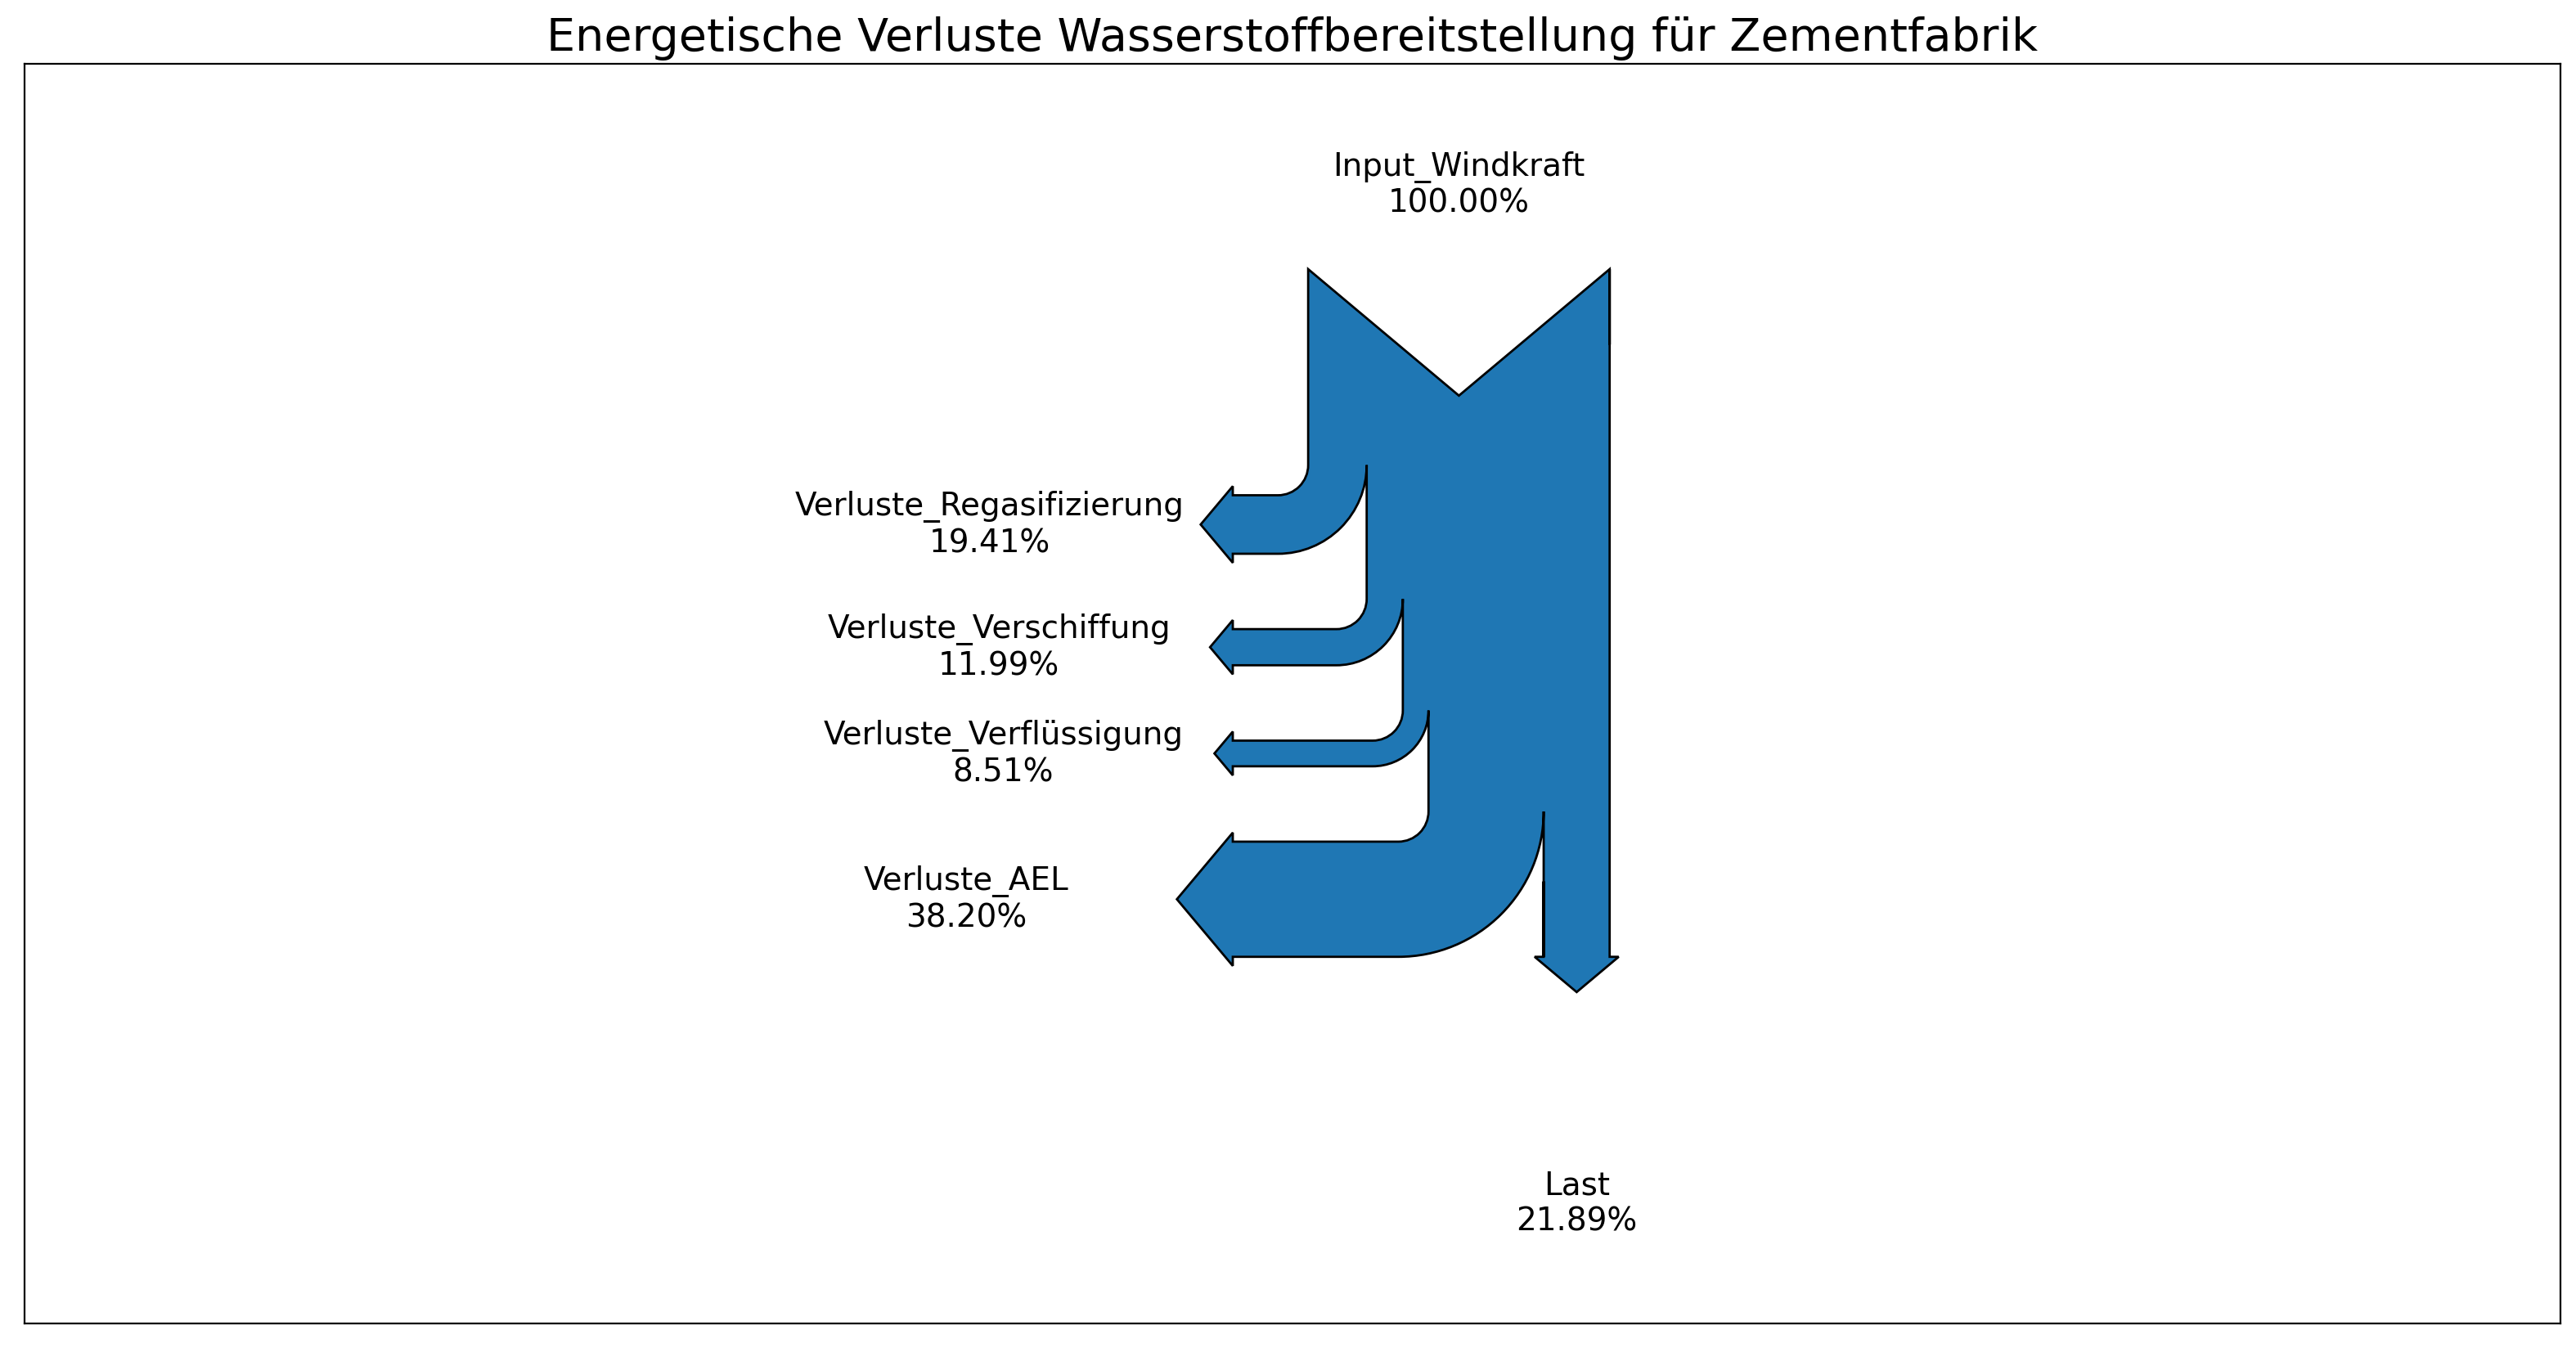

In [245]:
#Sankey Diagramm Verluste

from matplotlib.sankey import Sankey

sankey= Sankey(scale=0.01, offset=0.7,
                format='%.2f', unit='%')
sankey.add(flows=Verluste_Sankey_1.Verluste,labels=Verluste_Sankey_1.index,orientations=Verluste_Sankey_1.Orientierung,rotation=-90)
sankey.finish()
plt.title("Energetische Verluste Wasserstoffbereitstellung für Zementfabrik")

### Gestehungskosten Wasserstoff

In [246]:
# Berechnung des Wasserstoffpreises in €/kg

# Kilopreis der Generatoren
Generatorkosten = (((network1.generators.capital_cost * network1.generators.p_nom_opt)/network1.generators.lifetime
                    + network1.generators.marginal_cost * network1.generators_t.p.sum())/hydrogen_demand_kg).fillna(0)
     
Generatorkosten=pd.DataFrame(Generatorkosten,columns=['Preis [€/kg]'])

# Kilopreis der Links
Linkkosten = (((network1.links.p_nom_opt * network1.links.capital_cost)/network1.links.lifetime
              + network1.links.marginal_cost*(-network1.links_t.p1.sum()))
              /hydrogen_demand_kg)

Linkkosten=pd.DataFrame(Linkkosten,columns=['Preis [€/kg]'])

# Kilopreis der Speicher
Speicherkosten = (((network1.stores.e_nom_opt * network1.stores.capital_cost)/network1.stores.lifetime
                   + network1.stores.marginal_cost*network1.stores_t.e.sum())/hydrogen_demand_kg)

Speicherkosten=pd.DataFrame(Speicherkosten,columns=['Preis [€/kg]'])

Kilogrammpreis = (Generatorkosten.append(Linkkosten).append(Speicherkosten))


# Erstellung der Dataframes zur Darstellung in den Kategorien

Kilogrammpreis_Strom = pd.DataFrame((Kilogrammpreis.iloc[[0,1]].append(Kilogrammpreis.loc[['Stromspeicher']]).sum())).rename(index={'Preis [€/kg]': 'Stromkosten'})
Kilogrammpreis_Elektrolyse = pd.DataFrame(Kilogrammpreis.iloc[[2,3]].sum()).rename(index={'Preis [€/kg]': 'Elektrolyse'})
Kilogrammpreis_Umwandlung = pd.DataFrame(Kilogrammpreis.iloc[[4,5]].sum()).rename(index={'Preis [€/kg]': 'Umwandlung'})
Kilogrammpreis_Transport = pd.DataFrame(Kilogrammpreis.iloc[[6,7]].sum()).rename(index={'Preis [€/kg]': 'Transport'})
Kilogrammpreis_Speicherung = pd.DataFrame(Kilogrammpreis.iloc[[9,10]].sum()).rename(index={'Preis [€/kg]': 'Speicherung'})

Gestehungskosten_Wasserstoff_1 = (Kilogrammpreis_Strom
                                .append(Kilogrammpreis_Elektrolyse)
                                .append(Kilogrammpreis_Umwandlung)
                                .append(Kilogrammpreis_Transport)
                                .append(Kilogrammpreis_Speicherung)).rename(columns = {0:'Gestehungspreis [€/kg]'})

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\1437406784.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\1437406784.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\1437406784.py:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\1437406784.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\1437406784.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

In [247]:
# Ausgabe des Ergebnisses
Gestehungskosten_Wasserstoff_EUR_1 = float(round(Gestehungskosten_Wasserstoff_1.sum(),2))
print('Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei '+str(Gestehungskosten_Wasserstoff_EUR_1)+' €')

Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei 7.74 €


## Ausgabe der Ergebnistabellen (Netzwerk 2)

### Installierte Leistungen, Kapazitäten

In [248]:
# Ausgabe einer Ergebnistabelle der optimierten Leistungen in MW und optimierten Kapazitäten in MWh

df_results_1 = pd.DataFrame(network2.generators['p_nom_opt'])
df_results_2 = pd.DataFrame(network2.links['p_nom_opt'])
df_results_3 = pd.DataFrame(network2.stores['e_nom_opt'])

frames = [df_results_1, df_results_2, df_results_3]

results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {'p_nom_opt':'Leistung [MW]','e_nom_opt':'Speicherkapazität [MWh]'}))
results = results_x.loc[(results_x.sum(axis=1) != 0), (results_x.sum(axis=0) != 0)]
results

# Berechnung der jährlichen Volllaststunden

df_flh_1 = pd.DataFrame((network2.generators_t.p.sum())/network2.generators.p_nom_opt)
df_flh_2 = pd.DataFrame((network2.links_t.p0.sum())/network2.links.p_nom_opt)

df_flh_x = df_flh_1.append(df_flh_2).round(0).fillna(0)
df_flh = df_flh_x.loc[(df_flh_x.sum(axis=1) != 0), (df_flh_x.sum(axis=0) != 0)]
df_flh = df_flh.rename(columns = {0:'Volllast [h]'}).fillna(0)
#Berechnung der Energie 
df_results_1 = pd.DataFrame(network2.generators_t.p.sum())/1000
df_results_2 = pd.DataFrame(-network2.links_t.p1.sum())/1000
df_results_3 = pd.DataFrame(network2.stores_t.e.sum())/1000
frames = [df_results_1, df_results_2, df_results_3]
results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {0:'Energie [GWh]'}))

results_sum_energy_2 = pd.concat([results,df_flh,results_x],axis=1).fillna(0)
results_sum_energy_2

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\423592583.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Leistung [MW],Speicherkapazität [MWh],Volllast [h],Energie [GWh]
Windkraft,532.48,0.00,5705.0,3037.63
AEL,370.99,0.00,8188.0,1877.19
Haber-Bosch,229.26,0.00,8188.0,1727.02
NH3 Cracker,153.31,0.00,8760.0,1155.00
Verschiffung NH3,388.90,0.00,3861.0,1496.67
Pipeline,131.85,0.00,8760.0,1155.00
Stromspeicher,0.00,97556.70,0.0,521939.26
Ammoniakspeicher Chile,0.00,134309.79,0.0,563656.24
Ammoniakspeicher Bremerhaven,0.00,88294.89,0.0,384125.62
Photovoltaik,0.00,0.00,0.0,0.00


### Sankey Diagramm

In [249]:
#Sankey Diagramm_BErechnungen_NH3

Input_Photovoltaik= results_sum_energy_2['Energie [GWh]']['Photovoltaik']/(results_sum_energy_2['Energie [GWh]']['Photovoltaik']+results_sum_energy_2['Energie [GWh]']['Windkraft'])

Input_Windkraft= results_sum_energy_2['Energie [GWh]']['Windkraft']/(results_sum_energy_2['Energie [GWh]']['Photovoltaik']+results_sum_energy_2['Energie [GWh]']['Windkraft'])
Verluste_AEL= ((results_sum_energy_2['Energie [GWh]']['AEL']/(results_sum_energy_2['Energie [GWh]']['Photovoltaik']+results_sum_energy_2['Energie [GWh]']['Windkraft'])))

Verluste_Verflüssigung= ((results_sum_energy_2['Energie [GWh]']['Haber-Bosch']/(results_sum_energy_2['Energie [GWh]']['Photovoltaik']+results_sum_energy_2['Energie [GWh]']['Windkraft'])))

Verluste_Verschiffung= ((results_sum_energy_2['Energie [GWh]']['Verschiffung NH3']/(results_sum_energy_2['Energie [GWh]']['Photovoltaik']+results_sum_energy_2['Energie [GWh]']['Windkraft'])))

Verluste_Regasifizierung= ((results_sum_energy_2['Energie [GWh]']['NH3 Cracker']/(results_sum_energy_2['Energie [GWh]']['Photovoltaik']+results_sum_energy_2['Energie [GWh]']['Windkraft'])))
Verluste_Pipeline=  ((results_sum_energy_2['Energie [GWh]']['Pipeline']/(results_sum_energy_2['Energie [GWh]']['Photovoltaik']+results_sum_energy_2['Energie [GWh]']['Windkraft'])))
Last= -(1155/(results_sum_energy_2['Energie [GWh]']['Photovoltaik']+results_sum_energy_2['Energie [GWh]']['Windkraft']))

Verluste_Pipeline=-(Verluste_Regasifizierung-Verluste_Pipeline)
Verluste_Regasifizierung=-(Verluste_Verschiffung-Verluste_Regasifizierung)
Verluste_Verschiffung=-(Verluste_Verflüssigung-Verluste_Verschiffung)
Verluste_Verflüssigung=-(Verluste_AEL-Verluste_Verflüssigung)
Verluste_AEL=-(Input_Windkraft-Verluste_AEL)


Sankey_2={'Verluste':[Input_Photovoltaik, Input_Windkraft, Verluste_AEL,Verluste_Verflüssigung,Verluste_Verschiffung,Verluste_Regasifizierung,Verluste_Pipeline,Last],
        'Orientierung':[0,0,-1,-1,-1,-1,-1,0]}
Verluste_Sankey_2 = pd.DataFrame(data=Sankey_2,
                            index=['Input_Photovoltaik', 'Input_Windkraft', 'Verluste_AEL','Verluste_Haber-Bosch','Verluste_Verschiffung_NH3','Verluste_NH3_Cracker','Verluste_Pipeline','Last'])
Verluste_Sankey_2.Verluste = Verluste_Sankey_2.Verluste*100
Verluste_Sankey_2.Verluste = Verluste_Sankey_2.Verluste.replace(0, np.nan)
Verluste_Sankey_2 = Verluste_Sankey_2.dropna(axis=0)
#Verluste_Sankey_2


Text(0.5, 1.0, 'Energetische Verluste Wasserstoffbereitstellung für Zementfabrik')

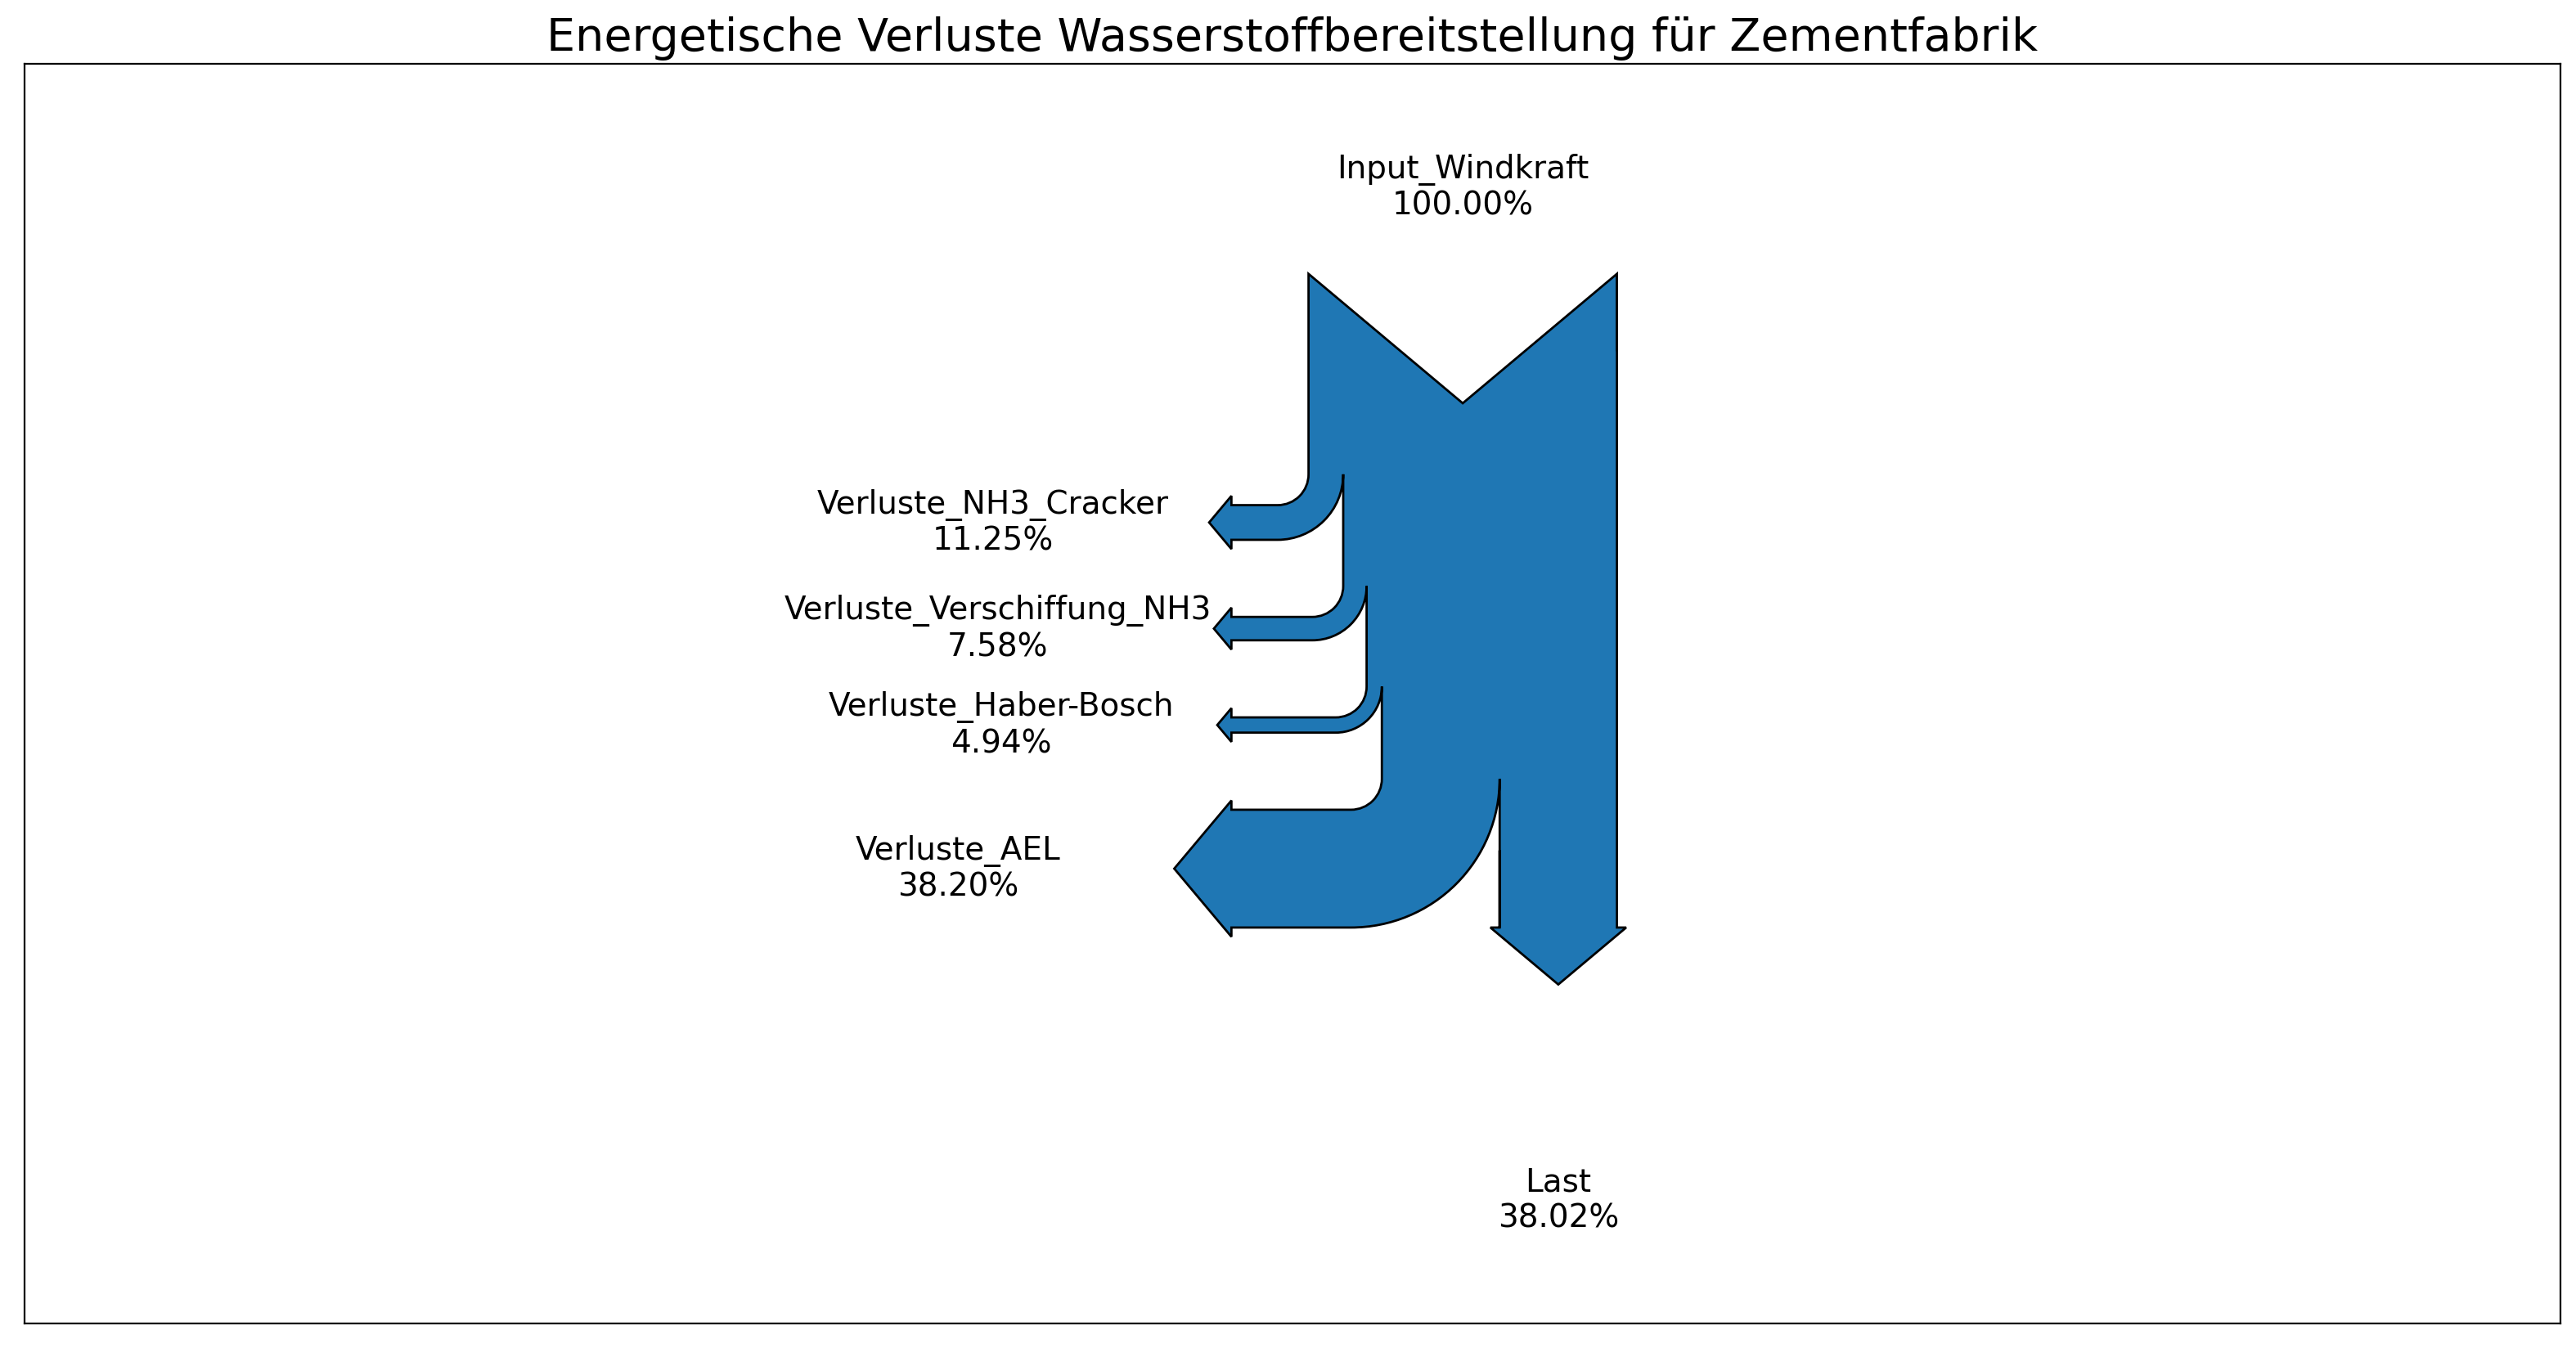

In [250]:
#Sankey Diagramm Verluste

from matplotlib.sankey import Sankey

sankey= Sankey(scale=0.01, offset=0.7,
                format='%.2f', unit='%')
sankey.add(flows=Verluste_Sankey_2.Verluste,labels=Verluste_Sankey_2.index,orientations=Verluste_Sankey_2.Orientierung,rotation=-90)
sankey.finish()
plt.title("Energetische Verluste Wasserstoffbereitstellung für Zementfabrik")

### Gestehungskosten Wasserstoff

In [251]:
# Berechnung des Wasserstoffpreises in €/kg

# Kilopreis der Generatoren
Generatorkosten = (((network2.generators.capital_cost * network2.generators.p_nom_opt)/network2.generators.lifetime
                    + network2.generators.marginal_cost * network2.generators_t.p.sum())/hydrogen_demand_kg).fillna(0)
     
Generatorkosten=pd.DataFrame(Generatorkosten,columns=['Preis [€/kg]'])

# Kilopreis der Links
Linkkosten = (((network2.links.p_nom_opt * network2.links.capital_cost)/network2.links.lifetime
              + network2.links.marginal_cost*(-network2.links_t.p1.sum()))
              /hydrogen_demand_kg)

Linkkosten=pd.DataFrame(Linkkosten,columns=['Preis [€/kg]'])

# Kilopreis der Speicher
Speicherkosten = (((network2.stores.e_nom_opt * network2.stores.capital_cost)/network2.stores.lifetime
                   + network2.stores.marginal_cost*network2.stores_t.e.sum())/hydrogen_demand_kg)

Speicherkosten=pd.DataFrame(Speicherkosten,columns=['Preis [€/kg]'])

Kilogrammpreis = (Generatorkosten.append(Linkkosten).append(Speicherkosten))

# Erstellung der Dataframes zur Darstellung in den Kategorien

Kilogrammpreis_Strom = pd.DataFrame((Kilogrammpreis.iloc[[0,1]].append(Kilogrammpreis.loc[['Stromspeicher']]).sum())).rename(index={'Preis [€/kg]': 'Stromkosten'})
Kilogrammpreis_Elektrolyse = pd.DataFrame(Kilogrammpreis.iloc[[2,3]].sum()).rename(index={'Preis [€/kg]': 'Elektrolyse'})
Kilogrammpreis_Umwandlung = pd.DataFrame(Kilogrammpreis.iloc[[4,5]].sum()).rename(index={'Preis [€/kg]': 'Umwandlung'})
Kilogrammpreis_Transport = pd.DataFrame(Kilogrammpreis.iloc[[6,7]].sum()).rename(index={'Preis [€/kg]': 'Transport'})
Kilogrammpreis_Speicherung = pd.DataFrame(Kilogrammpreis.iloc[[9,10]].sum()).rename(index={'Preis [€/kg]': 'Speicherung'})

Gestehungskosten_Wasserstoff_2 = (Kilogrammpreis_Strom
                                .append(Kilogrammpreis_Elektrolyse)
                                .append(Kilogrammpreis_Umwandlung)
                                .append(Kilogrammpreis_Transport)
                                .append(Kilogrammpreis_Speicherung)).rename(columns = {0:'Gestehungspreis [€/kg]'})

#Kilogrammpreis
#Gestehungskosten_Wasserstoff_2

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\594051177.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\594051177.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\594051177.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\594051177.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\594051177.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

In [252]:
# Ausgabe des Ergebnisses
Gestehungskosten_Wasserstoff_EUR_2 = float(round(Gestehungskosten_Wasserstoff_2.sum(),2))
print('Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei '+str(Gestehungskosten_Wasserstoff_EUR_2)+' €')

Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei 4.45 €


## Ausgabe der Ergebnistabellen (Netzwerk 3)

### Installierte Leistungen, Kapazitäten

In [253]:
# Ausgabe einer Ergebnistabelle der optimierten Leistungen in MW und optimierten Kapazitäten in MWh

df_results_1 = pd.DataFrame(network3.generators['p_nom_opt'])
df_results_2 = pd.DataFrame(network3.links['p_nom_opt'])
df_results_3 = pd.DataFrame(network3.stores['e_nom_opt'])

frames = [df_results_1, df_results_2, df_results_3]

results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {'p_nom_opt':'Leistung [MW]','e_nom_opt':'Speicherkapazität [MWh]'}))
results = results_x.loc[(results_x.sum(axis=1) != 0), (results_x.sum(axis=0) != 0)]
results

# Berechnung der jährlichen Volllaststunden

df_flh_1 = pd.DataFrame((network3.generators_t.p.sum())/network3.generators.p_nom_opt)
df_flh_2 = pd.DataFrame((network3.links_t.p0.sum())/network3.links.p_nom_opt)

df_flh_x = df_flh_1.append(df_flh_2).round(0).fillna(0)
df_flh = df_flh_x.loc[(df_flh_x.sum(axis=1) != 0), (df_flh_x.sum(axis=0) != 0)]
df_flh = df_flh.rename(columns = {0:'Volllast [h]'}).fillna(0)
#Berechnung der Energie 
df_results_1 = pd.DataFrame(network3.generators_t.p.sum())/1000
df_results_2 = pd.DataFrame(-network3.links_t.p1.sum())/1000
df_results_3 = pd.DataFrame(network3.stores_t.e.sum())/1000
frames = [df_results_1, df_results_2, df_results_3]
results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {0:'Energie [GWh]'}))
#df_flh

results_sum_energy_3 = pd.concat([results,df_flh,results_x],axis=1).fillna(0)
results_sum_energy_3

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\541894628.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Leistung [MW],Speicherkapazität [MWh],Volllast [h],Energie [GWh]
Windkraft,698.57,0.00,5705.0,3985.07
AEL,531.68,0.00,7495.0,2462.68
Hydrierung,328.57,0.00,7495.0,1723.88
Dehydrierung,196.79,0.00,8760.0,1155.00
Verschiffung LOHC,446.49,0.00,3861.0,1723.88
Pipeline,131.85,0.00,8760.0,1155.00
Stromspeicher,0.00,49462.46,0.0,203761.13
LOHC-Speicher Chile,0.00,188121.50,0.0,842719.53
LOHC-Speicher Bremerhaven,0.00,101969.19,0.0,446625.05
Photovoltaik,0.00,0.00,0.0,0.00


### Sankey Diagramm

In [254]:
#Sankey Diagramm_BErechnungen_LOHC

Input_Photovoltaik= results_sum_energy_3['Energie [GWh]']['Photovoltaik']/(results_sum_energy_3['Energie [GWh]']['Photovoltaik']+results_sum_energy_3['Energie [GWh]']['Windkraft'])

Input_Windkraft= results_sum_energy_3['Energie [GWh]']['Windkraft']/(results_sum_energy_3['Energie [GWh]']['Photovoltaik']+results_sum_energy_3['Energie [GWh]']['Windkraft'])
Verluste_AEL= ((results_sum_energy_3['Energie [GWh]']['AEL']/(results_sum_energy_3['Energie [GWh]']['Photovoltaik']+results_sum_energy_3['Energie [GWh]']['Windkraft'])))

Verluste_Verflüssigung= ((results_sum_energy_3['Energie [GWh]']['Hydrierung']/(results_sum_energy_3['Energie [GWh]']['Photovoltaik']+results_sum_energy_3['Energie [GWh]']['Windkraft'])))

Verluste_Verschiffung= ((results_sum_energy_3['Energie [GWh]']['Verschiffung LOHC']/(results_sum_energy_3['Energie [GWh]']['Photovoltaik']+results_sum_energy_3['Energie [GWh]']['Windkraft'])))

Verluste_Regasifizierung= ((results_sum_energy_3['Energie [GWh]']['Dehydrierung']/(results_sum_energy_3['Energie [GWh]']['Photovoltaik']+results_sum_energy_3['Energie [GWh]']['Windkraft'])))
Verluste_Pipeline=  ((results_sum_energy_3['Energie [GWh]']['Pipeline']/(results_sum_energy_3['Energie [GWh]']['Photovoltaik']+results_sum_energy_3['Energie [GWh]']['Windkraft'])))
Last= -(1155/(results_sum_energy_3['Energie [GWh]']['Photovoltaik']+results_sum_energy_3['Energie [GWh]']['Windkraft']))

Verluste_Pipeline=-(Verluste_Regasifizierung-Verluste_Pipeline)
Verluste_Regasifizierung=-(Verluste_Verschiffung-Verluste_Regasifizierung)
Verluste_Verschiffung=-(Verluste_Verflüssigung-Verluste_Verschiffung)
Verluste_Verflüssigung=-(Verluste_AEL-Verluste_Verflüssigung)
Verluste_AEL=-(Input_Windkraft-Verluste_AEL)


Sankey_3={'Verluste':[Input_Photovoltaik, Input_Windkraft, Verluste_AEL,Verluste_Verflüssigung,Verluste_Verschiffung,Verluste_Regasifizierung,Verluste_Pipeline,Last],
        'Orientierung':[0,0,-1,-1,-1,-1,-1,0]}
Verluste_Sankey_3 = pd.DataFrame(data=Sankey_3,
                            index=['Input_Photovoltaik', 'Input_Windkraft', 'Verluste_AEL','Verluste_Hydrierung','Verluste_Verschiffung_LOHC','Verluste_Dehydrierung','Verluste_Pipeline','Last'])
Verluste_Sankey_3.Verluste = Verluste_Sankey_3.Verluste*100
Verluste_Sankey_3.Verluste = Verluste_Sankey_3.Verluste.replace(0, np.nan)
Verluste_Sankey_3 = Verluste_Sankey_3.dropna(axis=0)
#Verluste_Sankey_3


Text(0.5, 1.0, 'Energetische Verluste Wasserstoffbereitstellung für Zementfabrik')

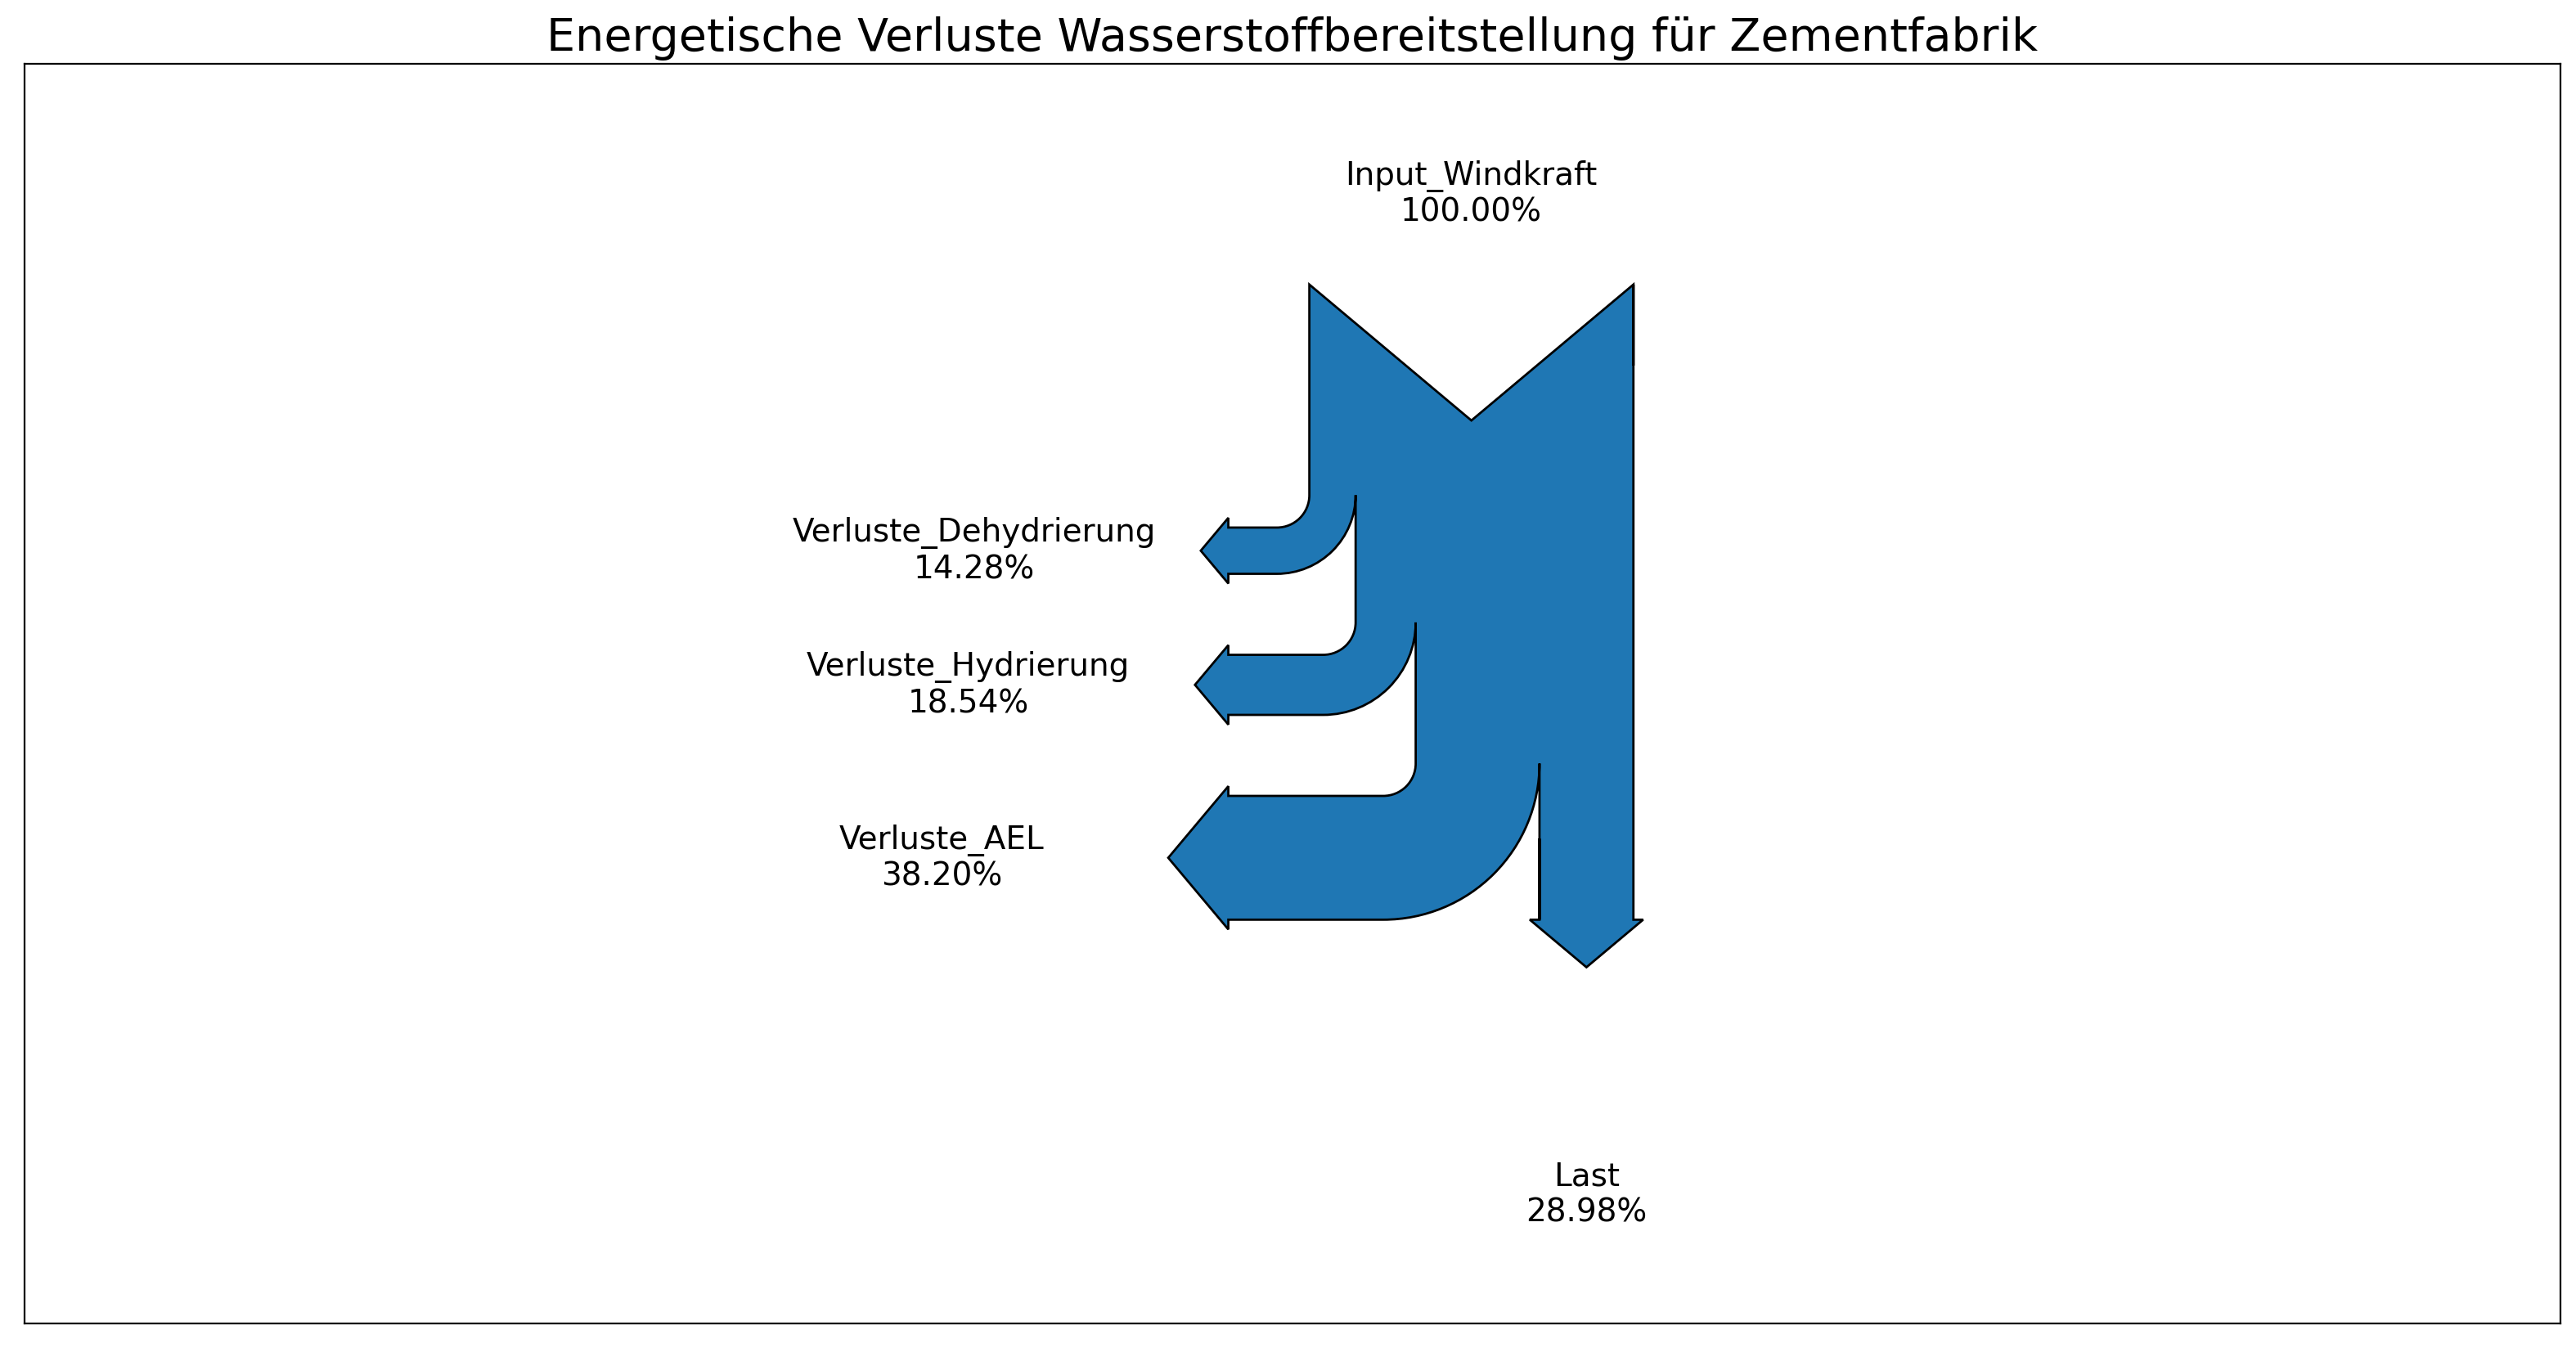

In [255]:
#Sankey Diagramm Verluste

from matplotlib.sankey import Sankey

sankey= Sankey(scale=0.01, offset=0.7,
                format='%.2f', unit='%')
sankey.add(flows=Verluste_Sankey_3.Verluste,labels=Verluste_Sankey_3.index,orientations=Verluste_Sankey_3.Orientierung,rotation=-90)
sankey.finish()
plt.title("Energetische Verluste Wasserstoffbereitstellung für Zementfabrik")

### Gestehungskosten Wasserstoff

In [256]:
# Berechnung des Wasserstoffpreises in €/kg

# Kilopreis der Generatoren
Generatorkosten = (((network3.generators.capital_cost * network3.generators.p_nom_opt)/network3.generators.lifetime
                    + network3.generators.marginal_cost * network3.generators_t.p.sum())/hydrogen_demand_kg).fillna(0)
     
Generatorkosten=pd.DataFrame(Generatorkosten,columns=['Preis [€/kg]'])

# Kilopreis der Links
Linkkosten = (((network3.links.p_nom_opt * network3.links.capital_cost)/network3.links.lifetime
              + network3.links.marginal_cost*(-network3.links_t.p1.sum()))
              /hydrogen_demand_kg)

Linkkosten=pd.DataFrame(Linkkosten,columns=['Preis [€/kg]'])

# Kilopreis der Speicher
Speicherkosten = (((network3.stores.e_nom_opt * network3.stores.capital_cost)/network3.stores.lifetime
                   + network3.stores.marginal_cost*network3.stores_t.e.sum())/hydrogen_demand_kg)

Speicherkosten=pd.DataFrame(Speicherkosten,columns=['Preis [€/kg]'])


Kilogrammpreis = (Generatorkosten.append(Linkkosten).append(Speicherkosten))

# Erstellung der Dataframes zur Darstellung in den Kategorien
Kilogrammpreis_Strom = pd.DataFrame((Kilogrammpreis.iloc[[0,1]].append(Kilogrammpreis.loc[['Stromspeicher']]).sum())).rename(index={'Preis [€/kg]': 'Stromkosten'})
Kilogrammpreis_Elektrolyse = pd.DataFrame(Kilogrammpreis.iloc[[2,3]].sum()).rename(index={'Preis [€/kg]': 'Elektrolyse'})
Kilogrammpreis_Umwandlung = pd.DataFrame(Kilogrammpreis.iloc[[4,5]].sum()).rename(index={'Preis [€/kg]': 'Umwandlung'})
Kilogrammpreis_Transport = pd.DataFrame(Kilogrammpreis.iloc[[6,7]].sum()).rename(index={'Preis [€/kg]': 'Transport'})
Kilogrammpreis_Speicherung = pd.DataFrame(Kilogrammpreis.iloc[[9,10]].sum()).rename(index={'Preis [€/kg]': 'Speicherung'})

Gestehungskosten_Wasserstoff_3 = (Kilogrammpreis_Strom
                                .append(Kilogrammpreis_Elektrolyse)
                                .append(Kilogrammpreis_Umwandlung)
                                .append(Kilogrammpreis_Transport)
                                .append(Kilogrammpreis_Speicherung)).rename(columns = {0:'Gestehungspreis [€/kg]'})

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\2016698520.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\2016698520.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\2016698520.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\2016698520.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\mathi\AppData\Local\Temp\ipykernel_13040\2016698520.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

In [257]:
# Ausgabe des Ergebnisses
Gestehungskosten_Wasserstoff_EUR_3 = float(round(Gestehungskosten_Wasserstoff_3.sum(),2))
print('Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei '+str(Gestehungskosten_Wasserstoff_EUR_3)+' €')

Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei 5.22 €


## Ergebnisübersicht

In [258]:
# Ergebnisse

results = [Gestehungskosten_Wasserstoff_1,Gestehungskosten_Wasserstoff_2,Gestehungskosten_Wasserstoff_3]

results_sum = pd.concat(results, axis = 1)
results_sum

,Gestehungspreis [€/kg],Gestehungspreis [€/kg],Gestehungspreis [€/kg]
Stromkosten,5.231206,2.895496,3.716663
Elektrolyse,2.368434,0.864160,1.214661
Umwandlung,0.000000,0.479301,0.094666
Transport,0.135616,0.131193,0.129487
Speicherung,0.000000,0.081092,0.066030


## Grafische Darstellungen

### Darstellung der optimierten Erzeugungsleistung

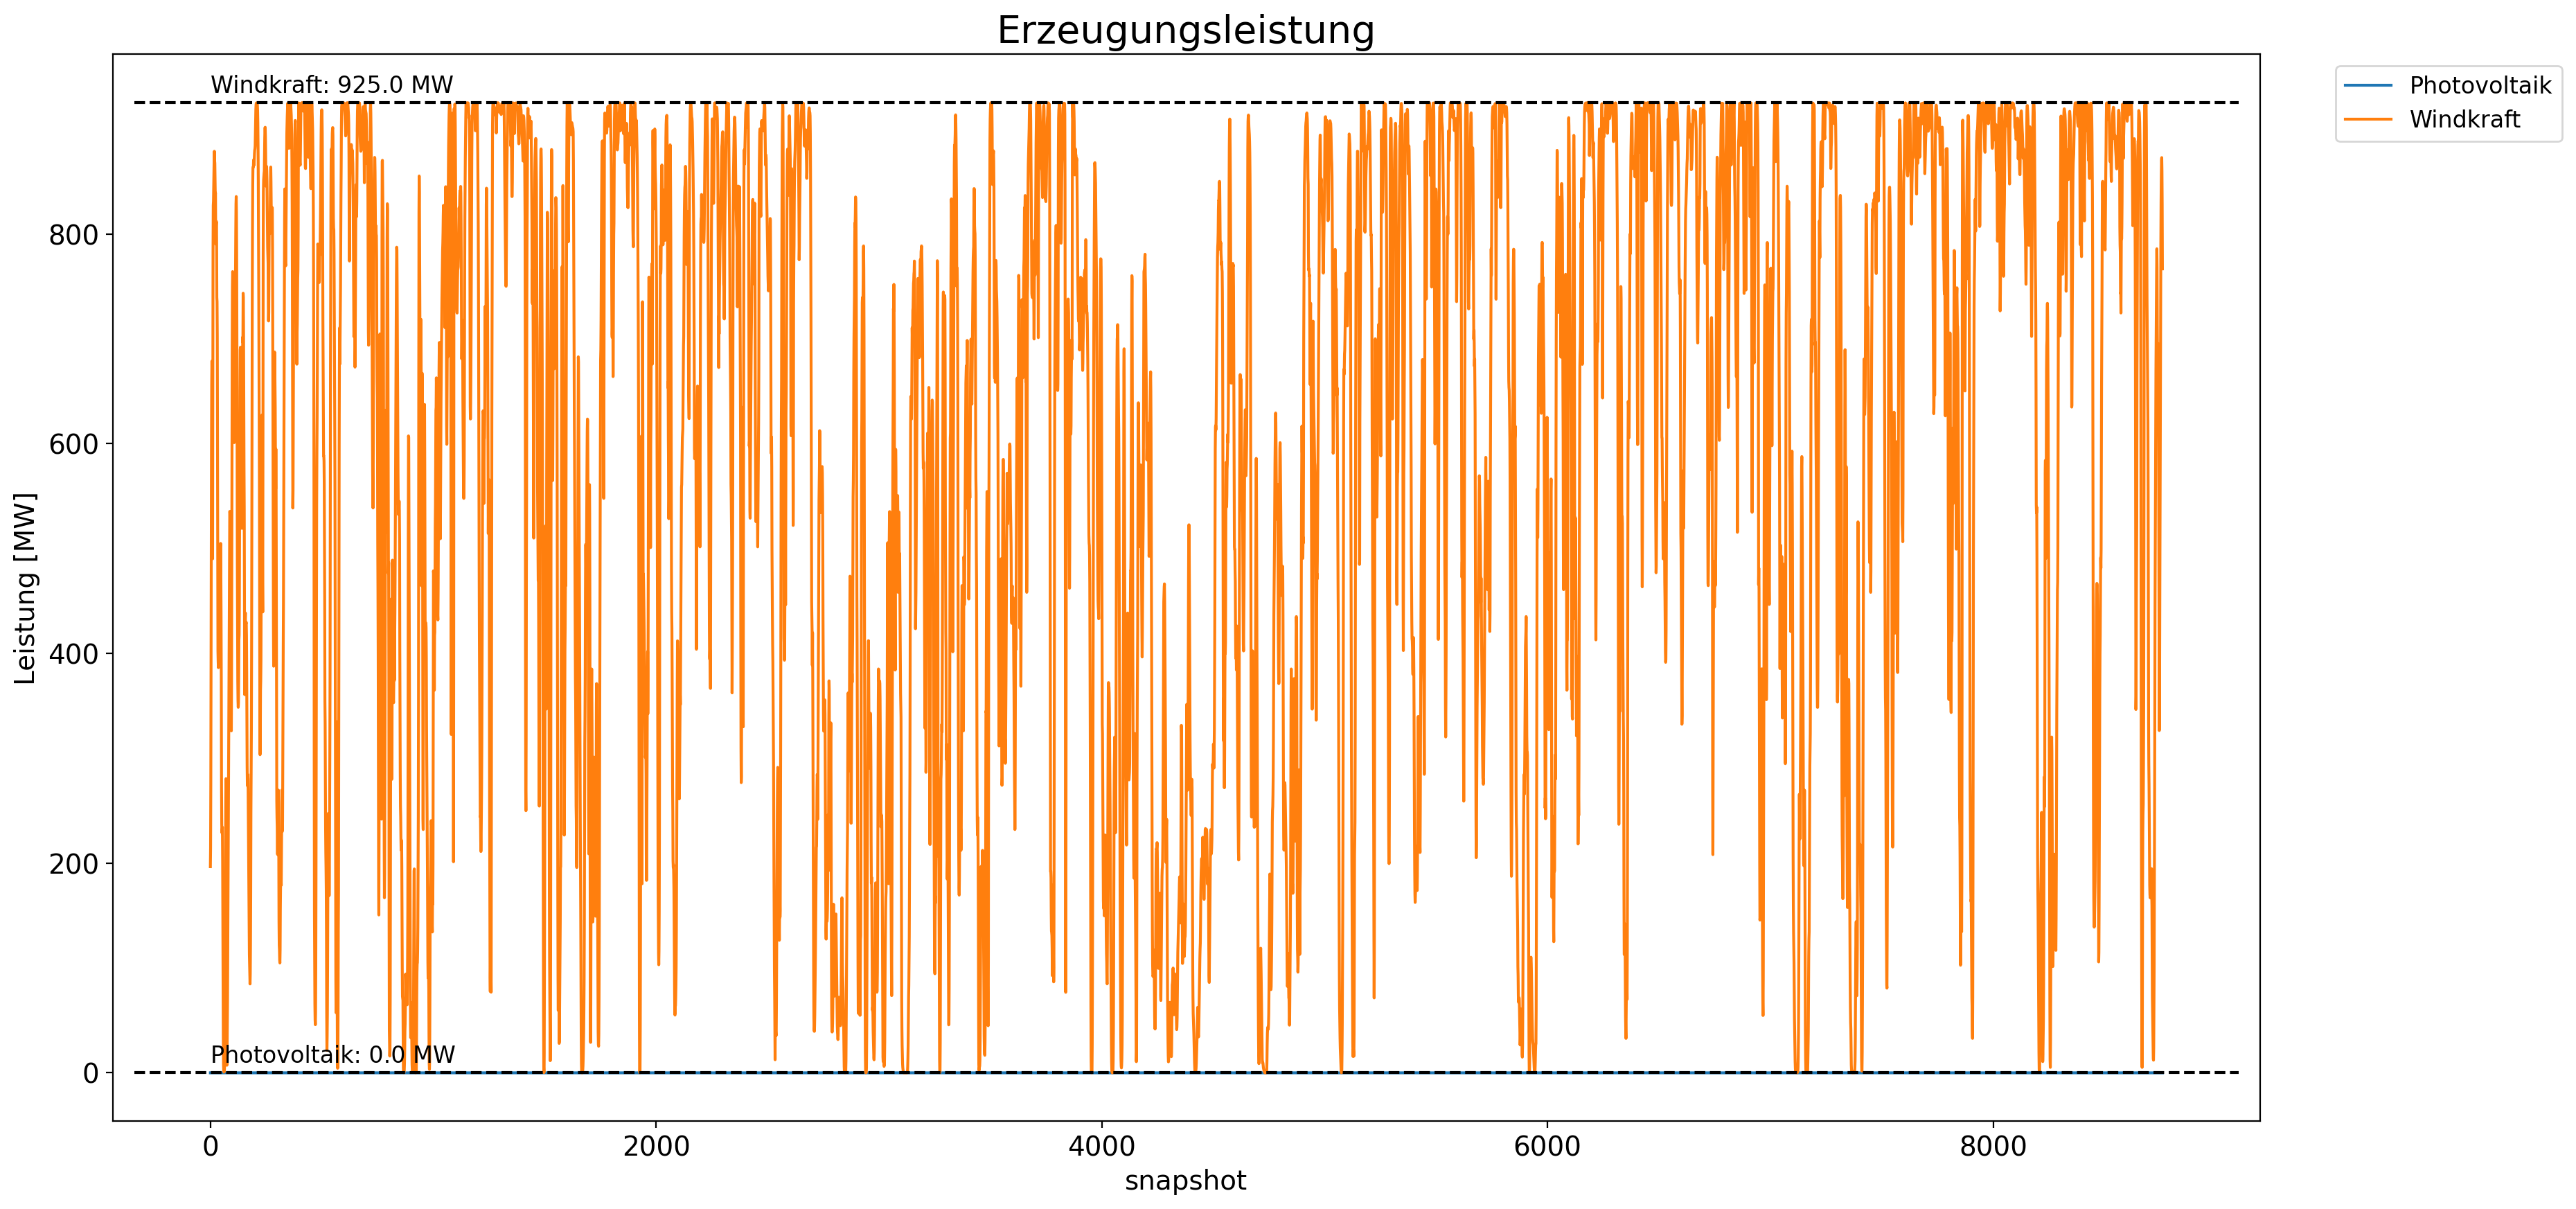

In [259]:
# Plot

ax = network1.generators_t.p.plot()

plt.axhline(y=network1.generators_t.p['Photovoltaik'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")
plt.axhline(y=network1.generators_t.p['Windkraft'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")

plt.text(s = 'Photovoltaik: '+str(network1.generators.p_nom_opt.round(0)['Photovoltaik'])+' MW' , y = network1.generators_t.p['Photovoltaik'].max() + 10, x = 0, color = 'black', fontsize = 12)
plt.text(s = 'Windkraft: '+str(network1.generators.p_nom_opt.round(0)['Windkraft'])+' MW', y = network1.generators_t.p['Windkraft'].max() + 10, x = 0, color = 'black', fontsize = 12)

ax.set_title('Erzeugungsleistung')
ax.set_ylabel("Leistung [MW]")
horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.show()                  

### Darstellung der optimierten Erzeugungsleistung als Jahresdauerline

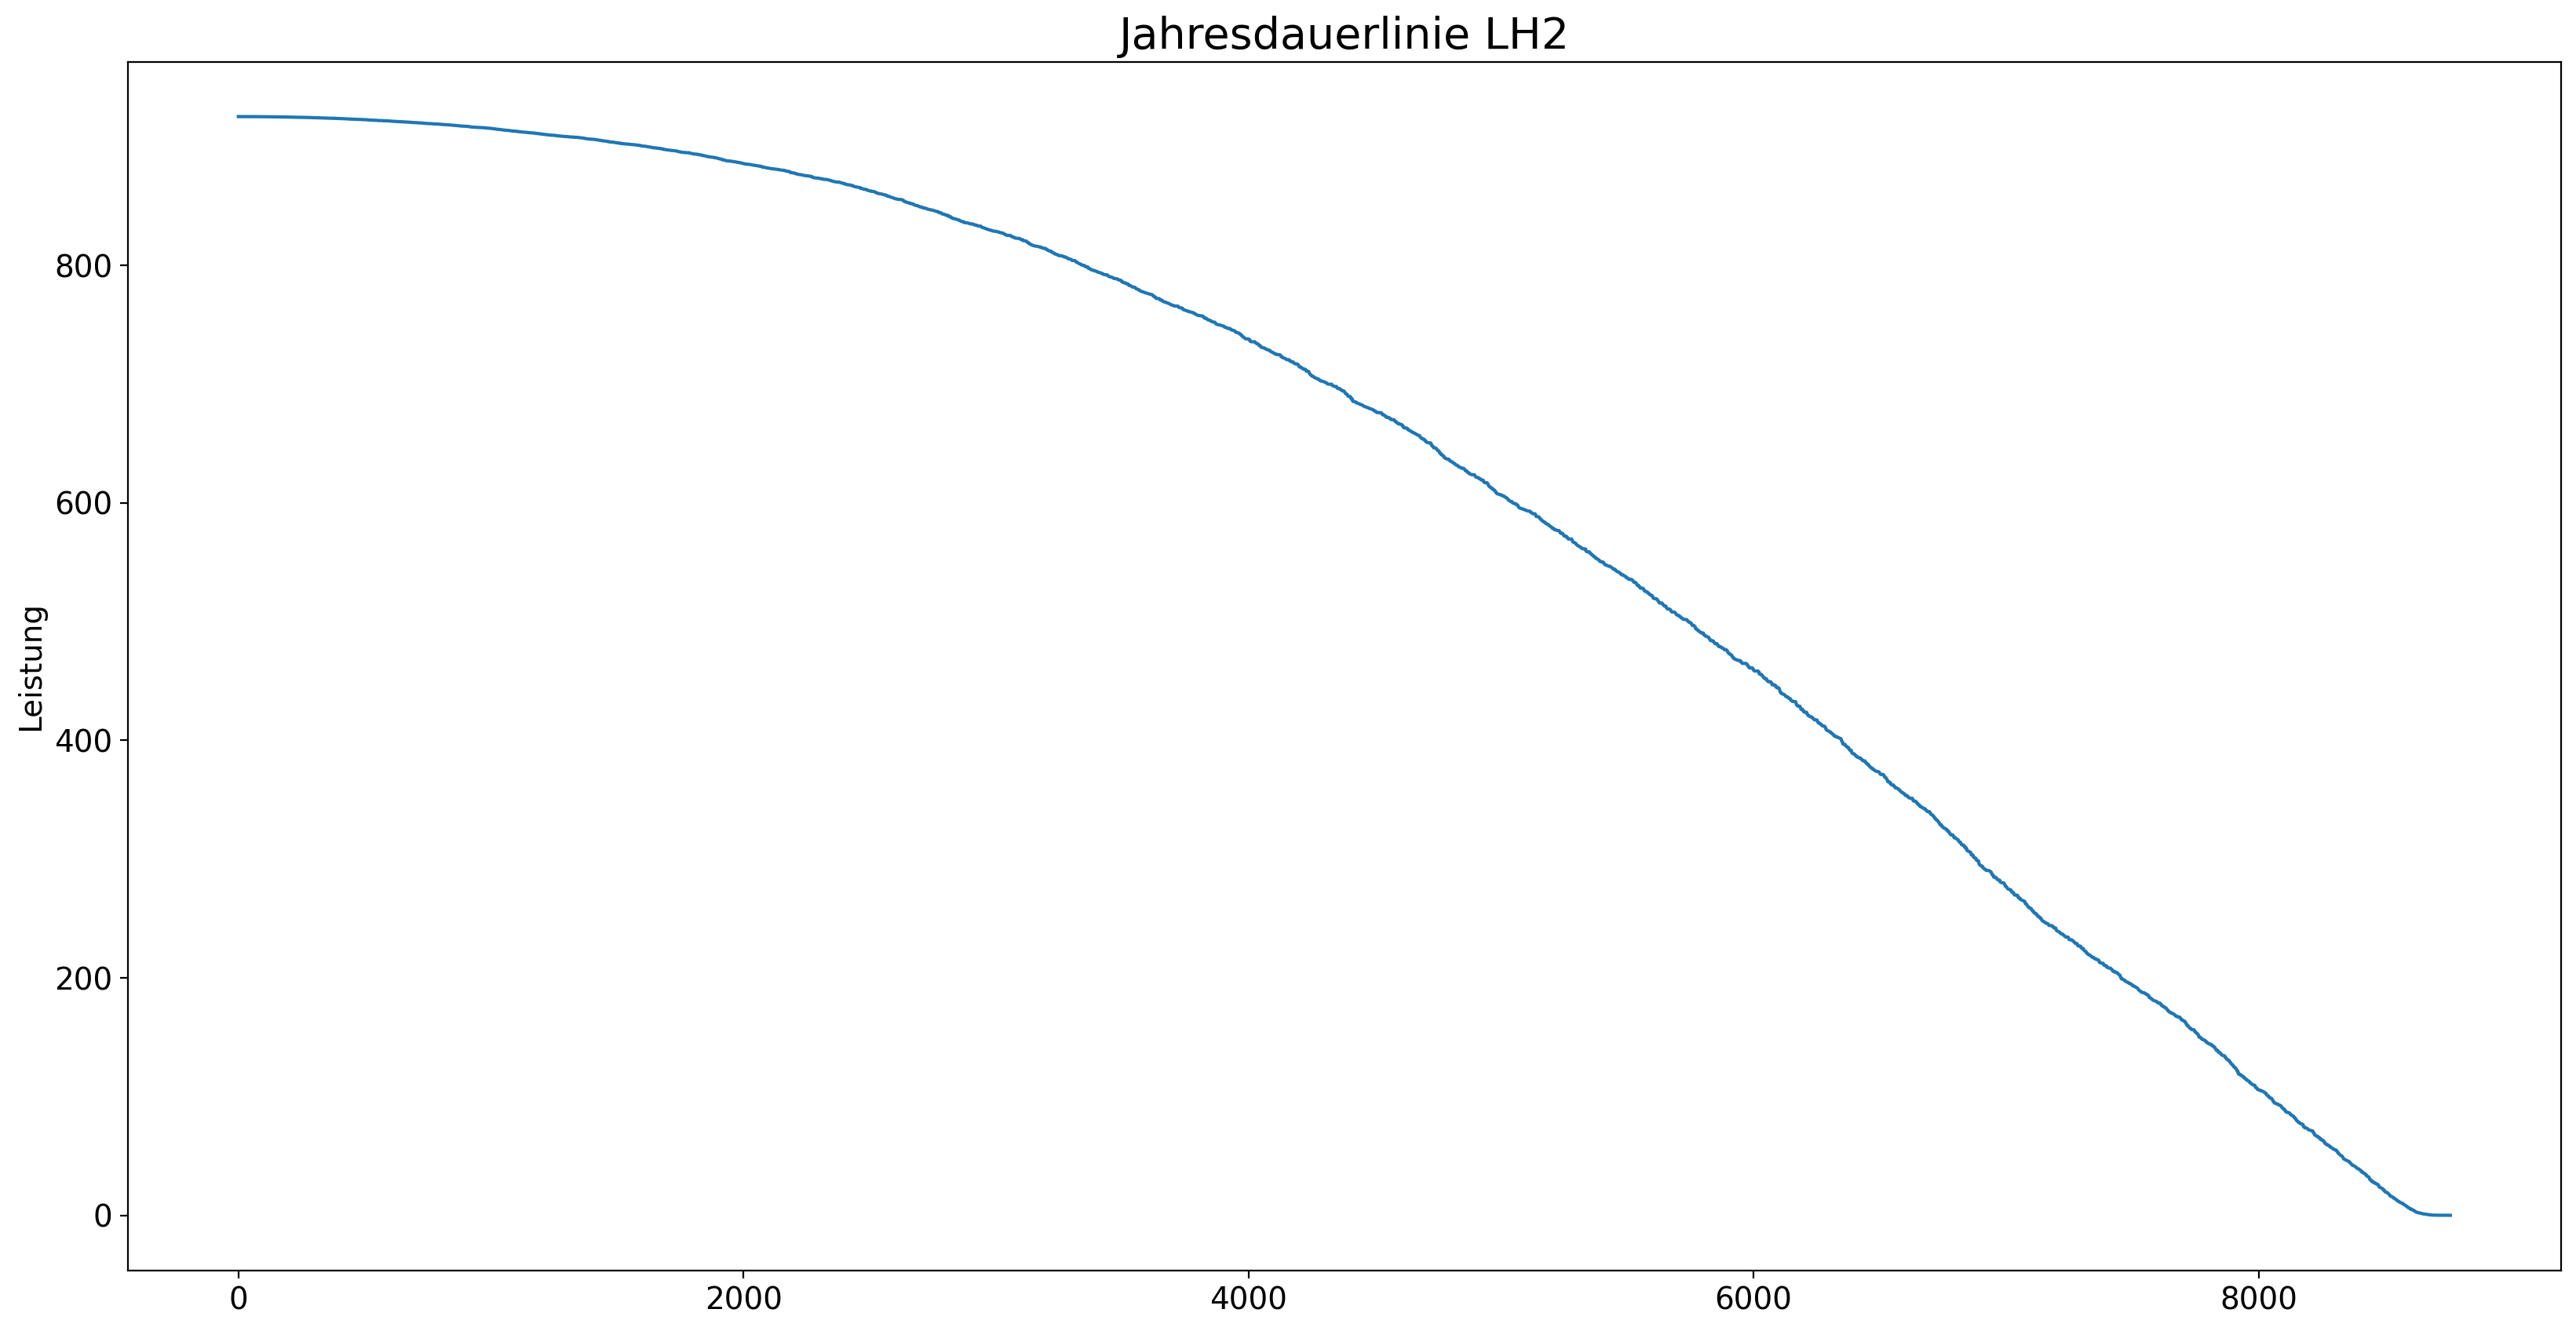

In [260]:
Dauerlinie(network1.generators_t.p,'Windkraft','Jahresdauerlinie LH2','Leistung')

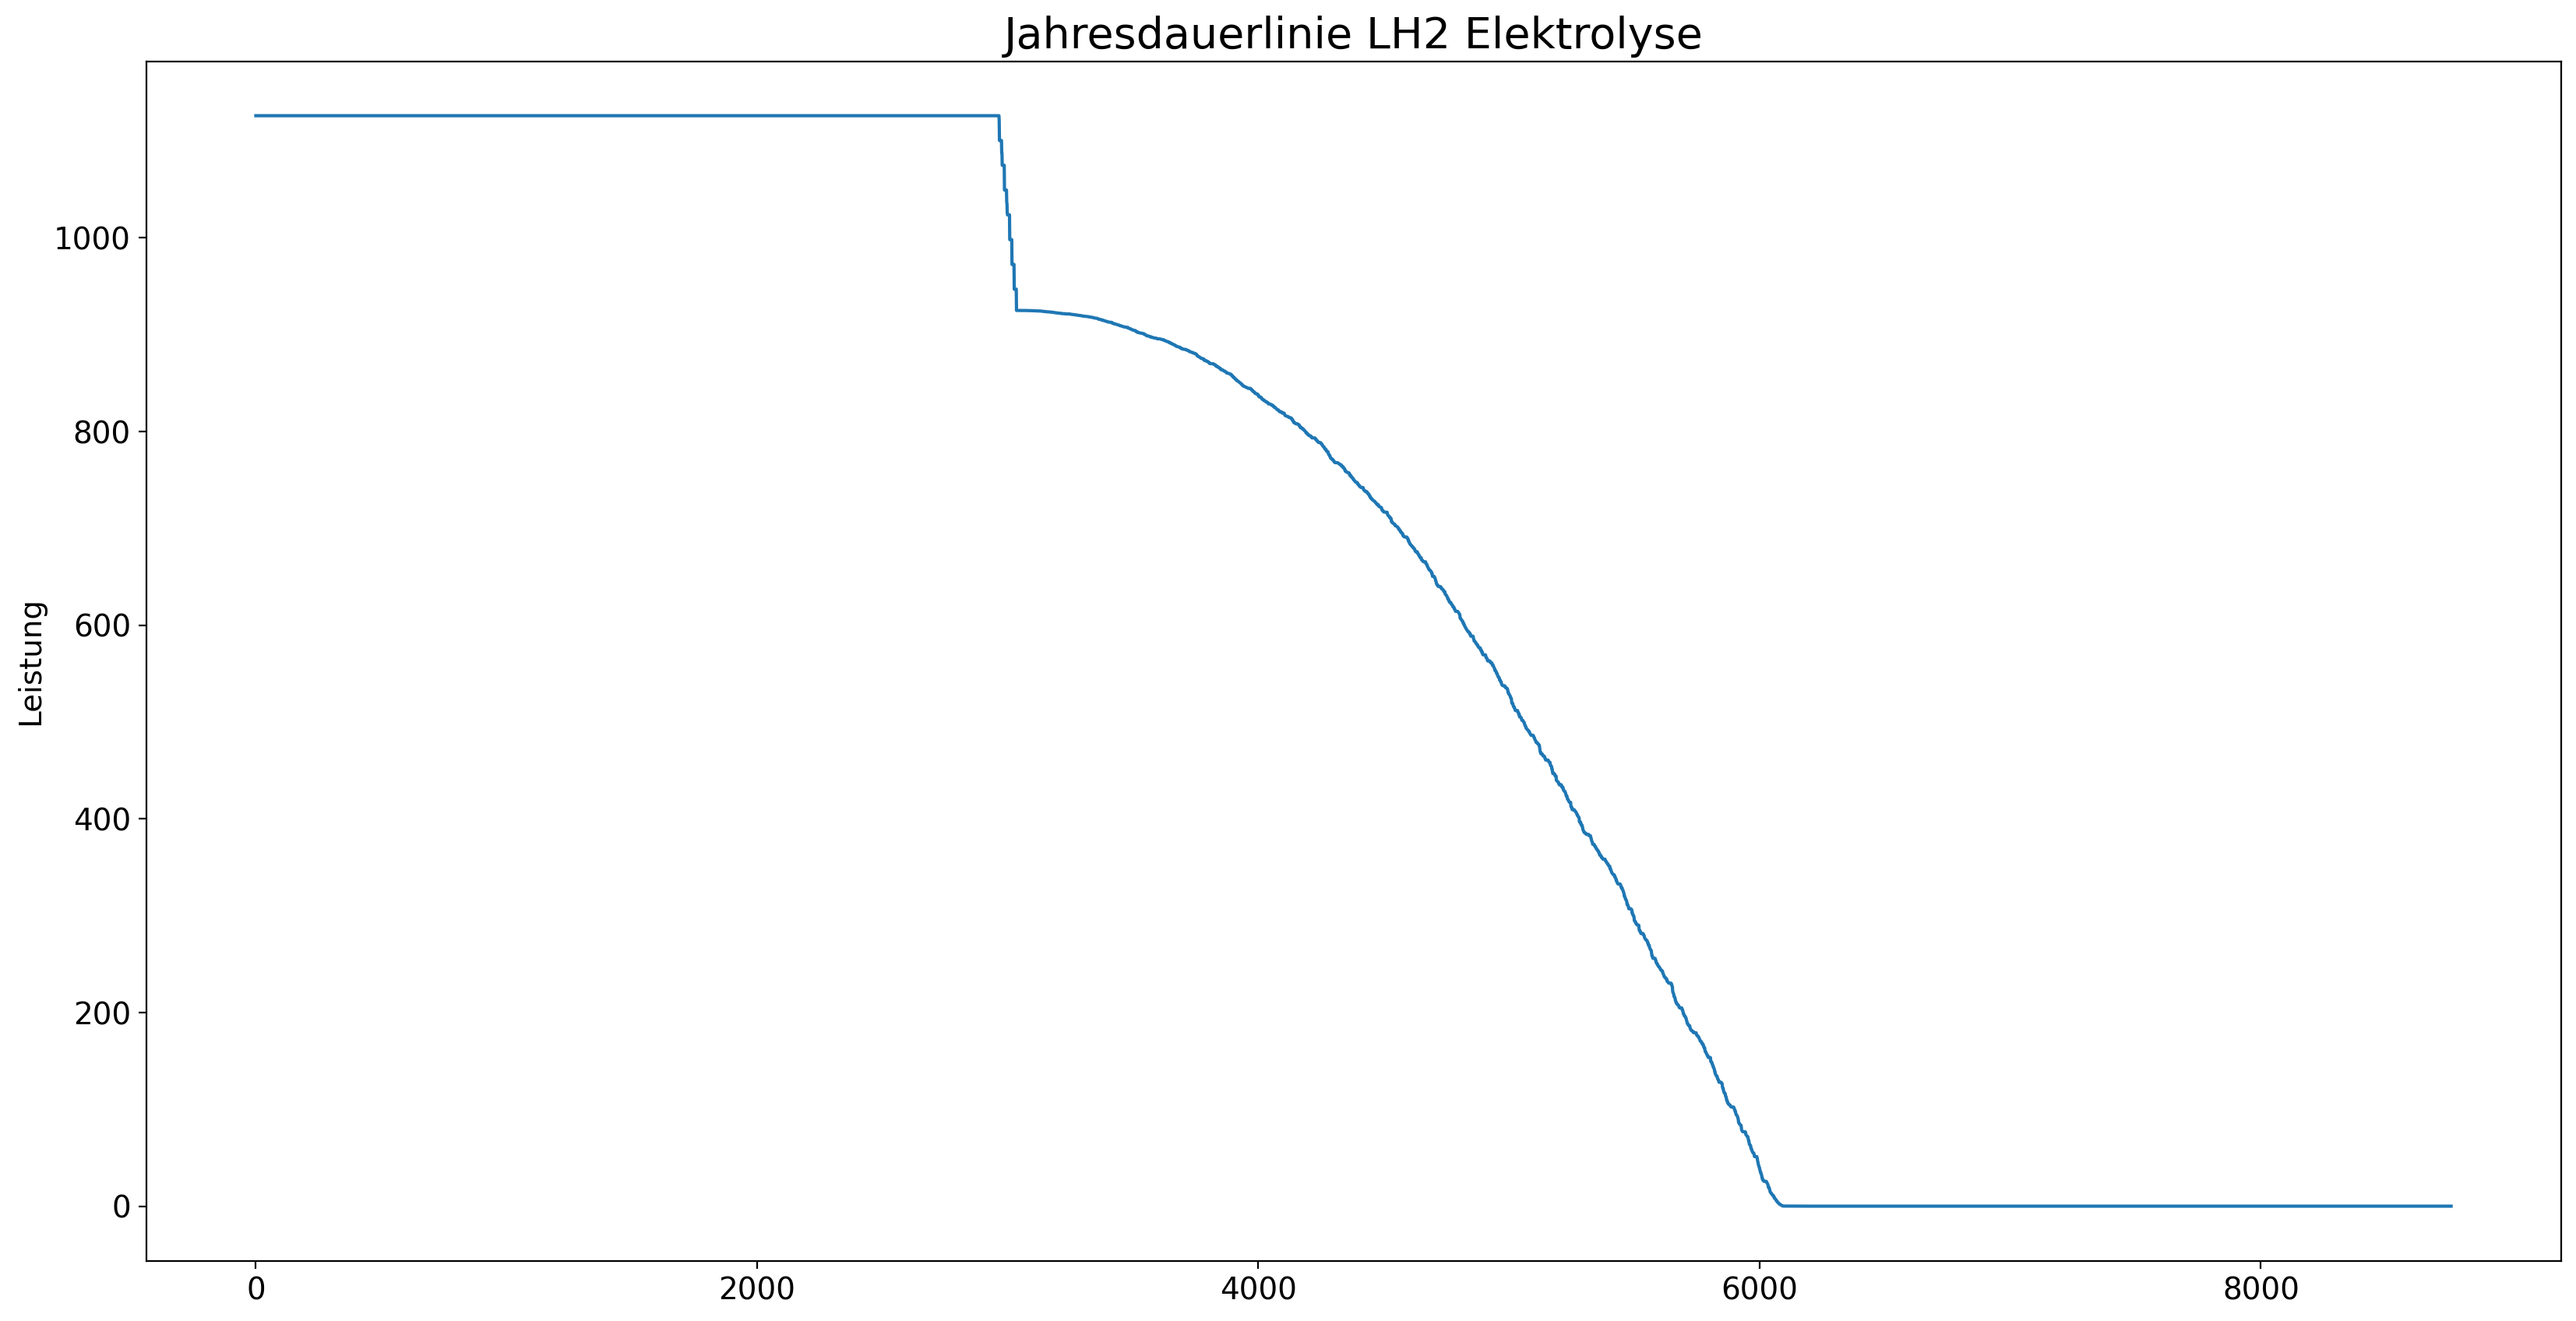

In [261]:
Dauerlinie(network1.links_t.p0,'AEL','Jahresdauerlinie LH2 Elektrolyse','Leistung')

### Darstellung der optimierten Elektrolyseleistung

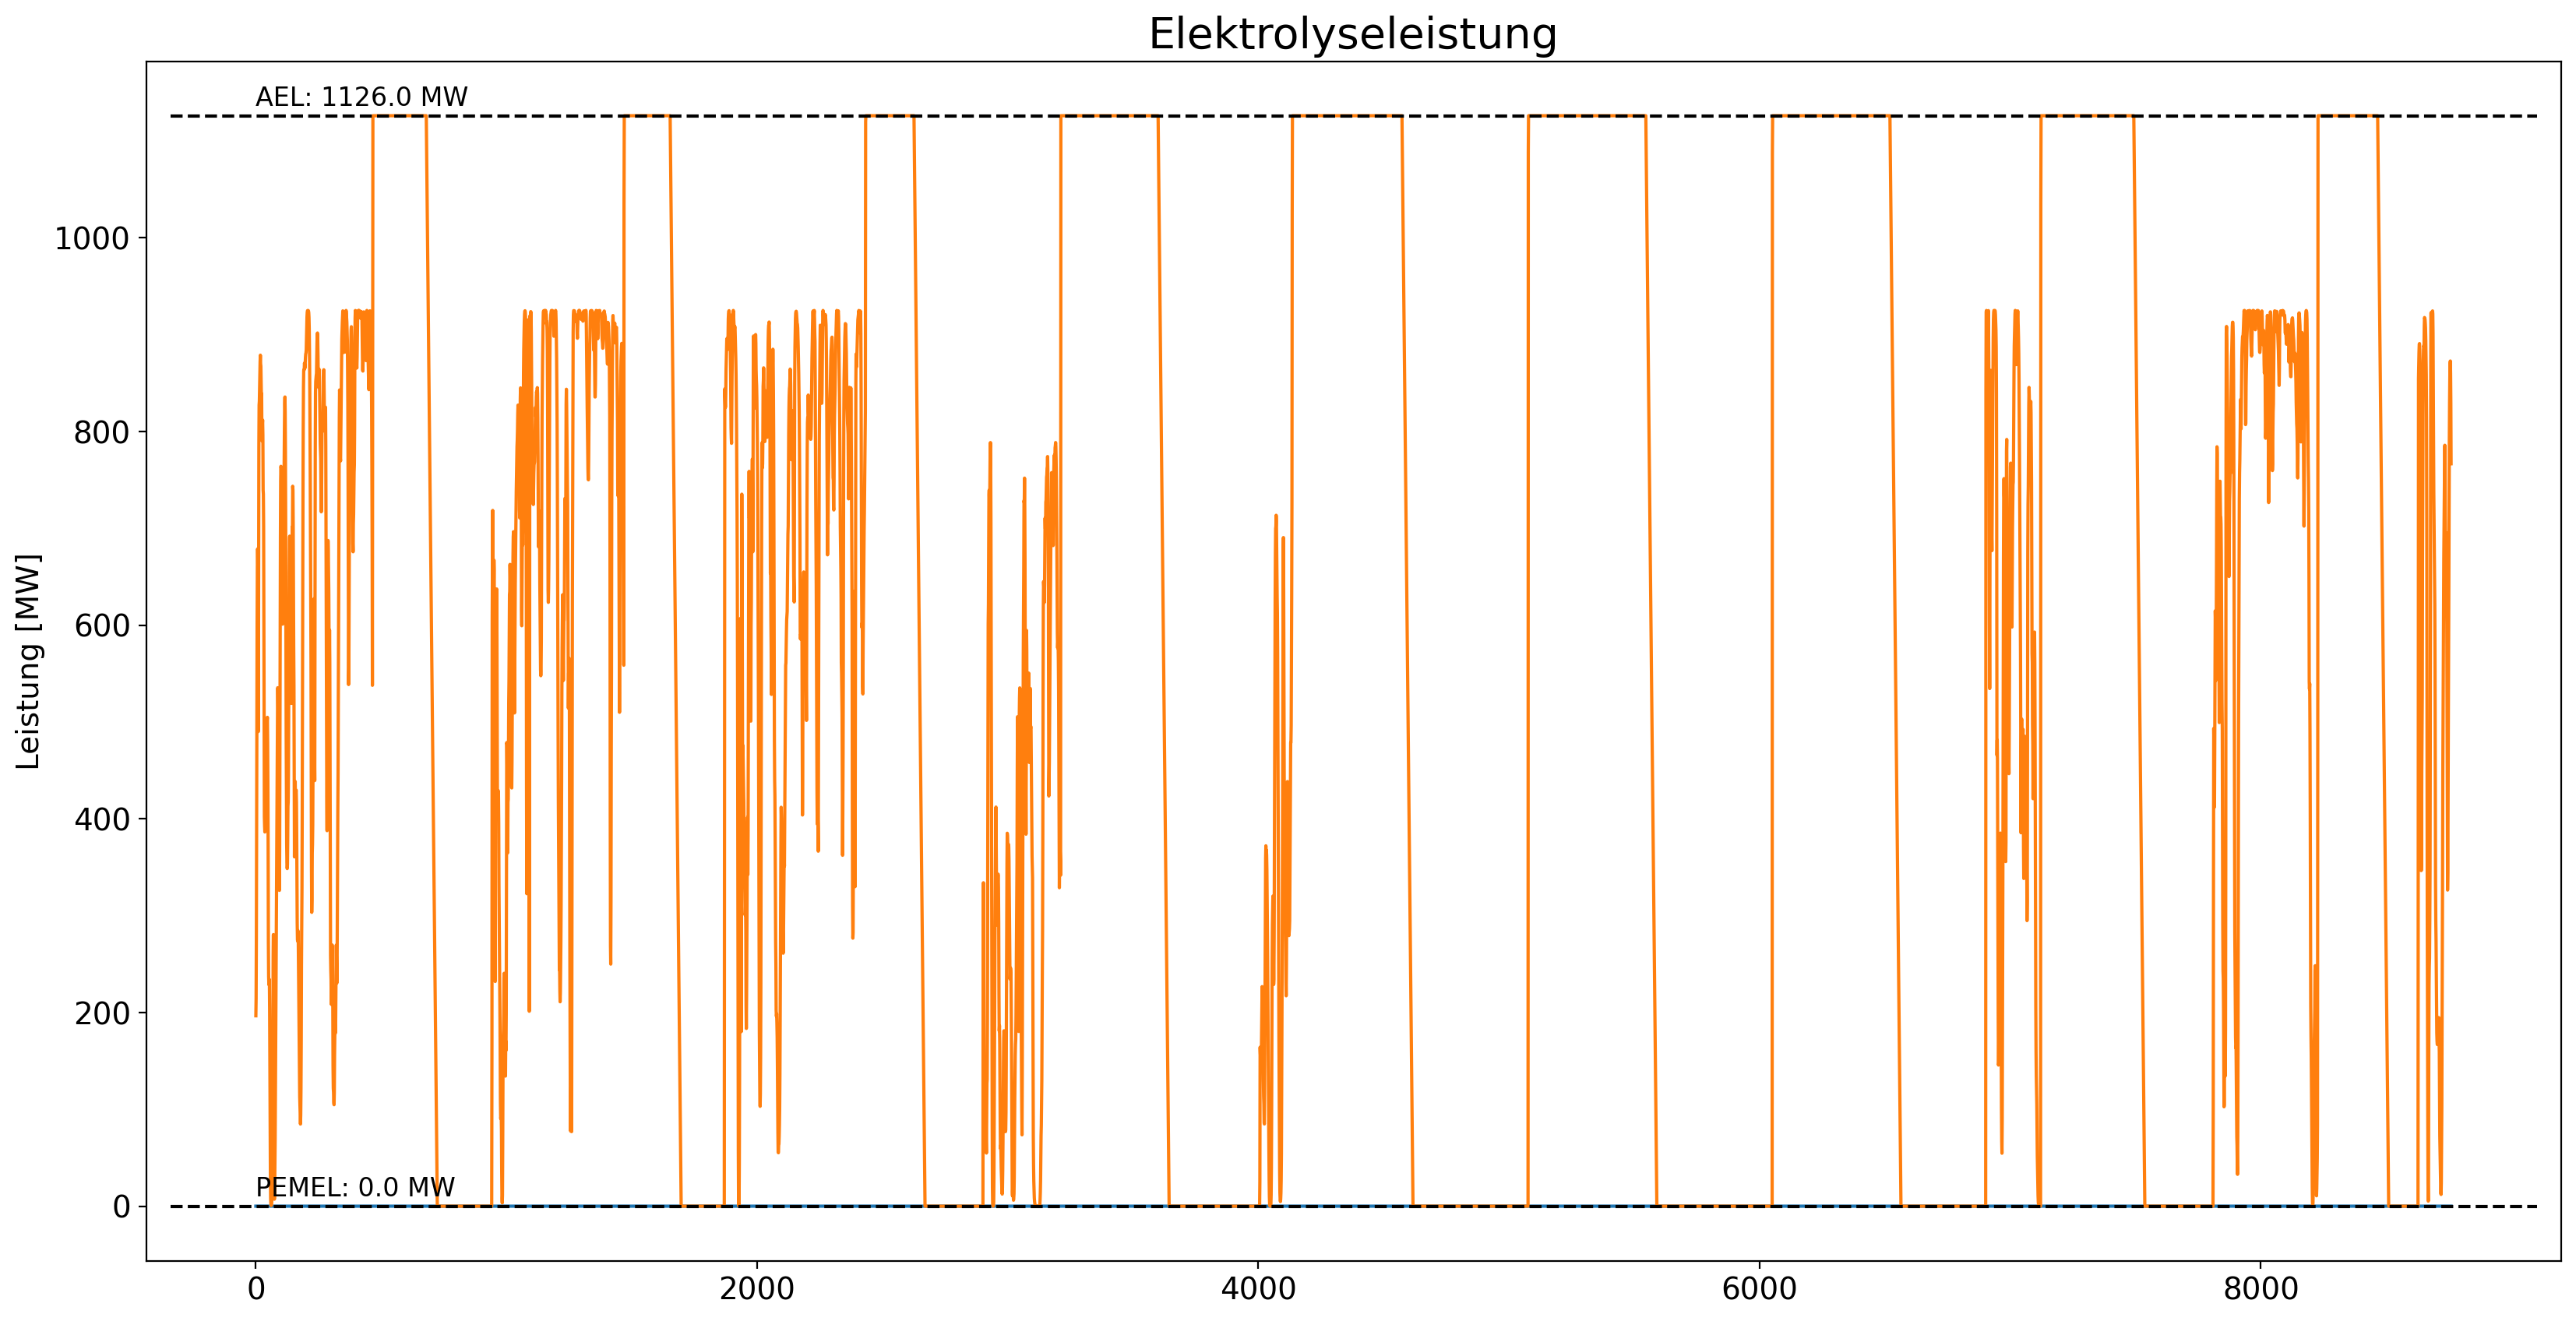

In [262]:
# Darstellung der optimierten Elektrolyseleistung

fig, ax = plt.subplots()

ax.plot(network1.links_t.p0['PEMEL'])
ax.plot(network1.links_t.p0['AEL'])

plt.axhline(y=network1.links_t.p0['PEMEL'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")
plt.axhline(y=network1.links_t.p0['AEL'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")

plt.text(s = 'PEMEL: '+str(network1.links.p_nom_opt.round(0)['PEMEL'])+' MW' , y = network1.links_t.p0['PEMEL'].max() + 10, x = 0, color = 'black', fontsize = 12)
plt.text(s = 'AEL: '+str(network1.links.p_nom_opt.round(0)['AEL'])+' MW', y = network1.links_t.p0['AEL'].max() + 10, x = 0, color = 'black', fontsize = 12)

ax.set_title('Elektrolyseleistung')
ax.set_ylabel("Leistung [MW]")
plt.show()         

### Darstellung der Bereitstellungskosten

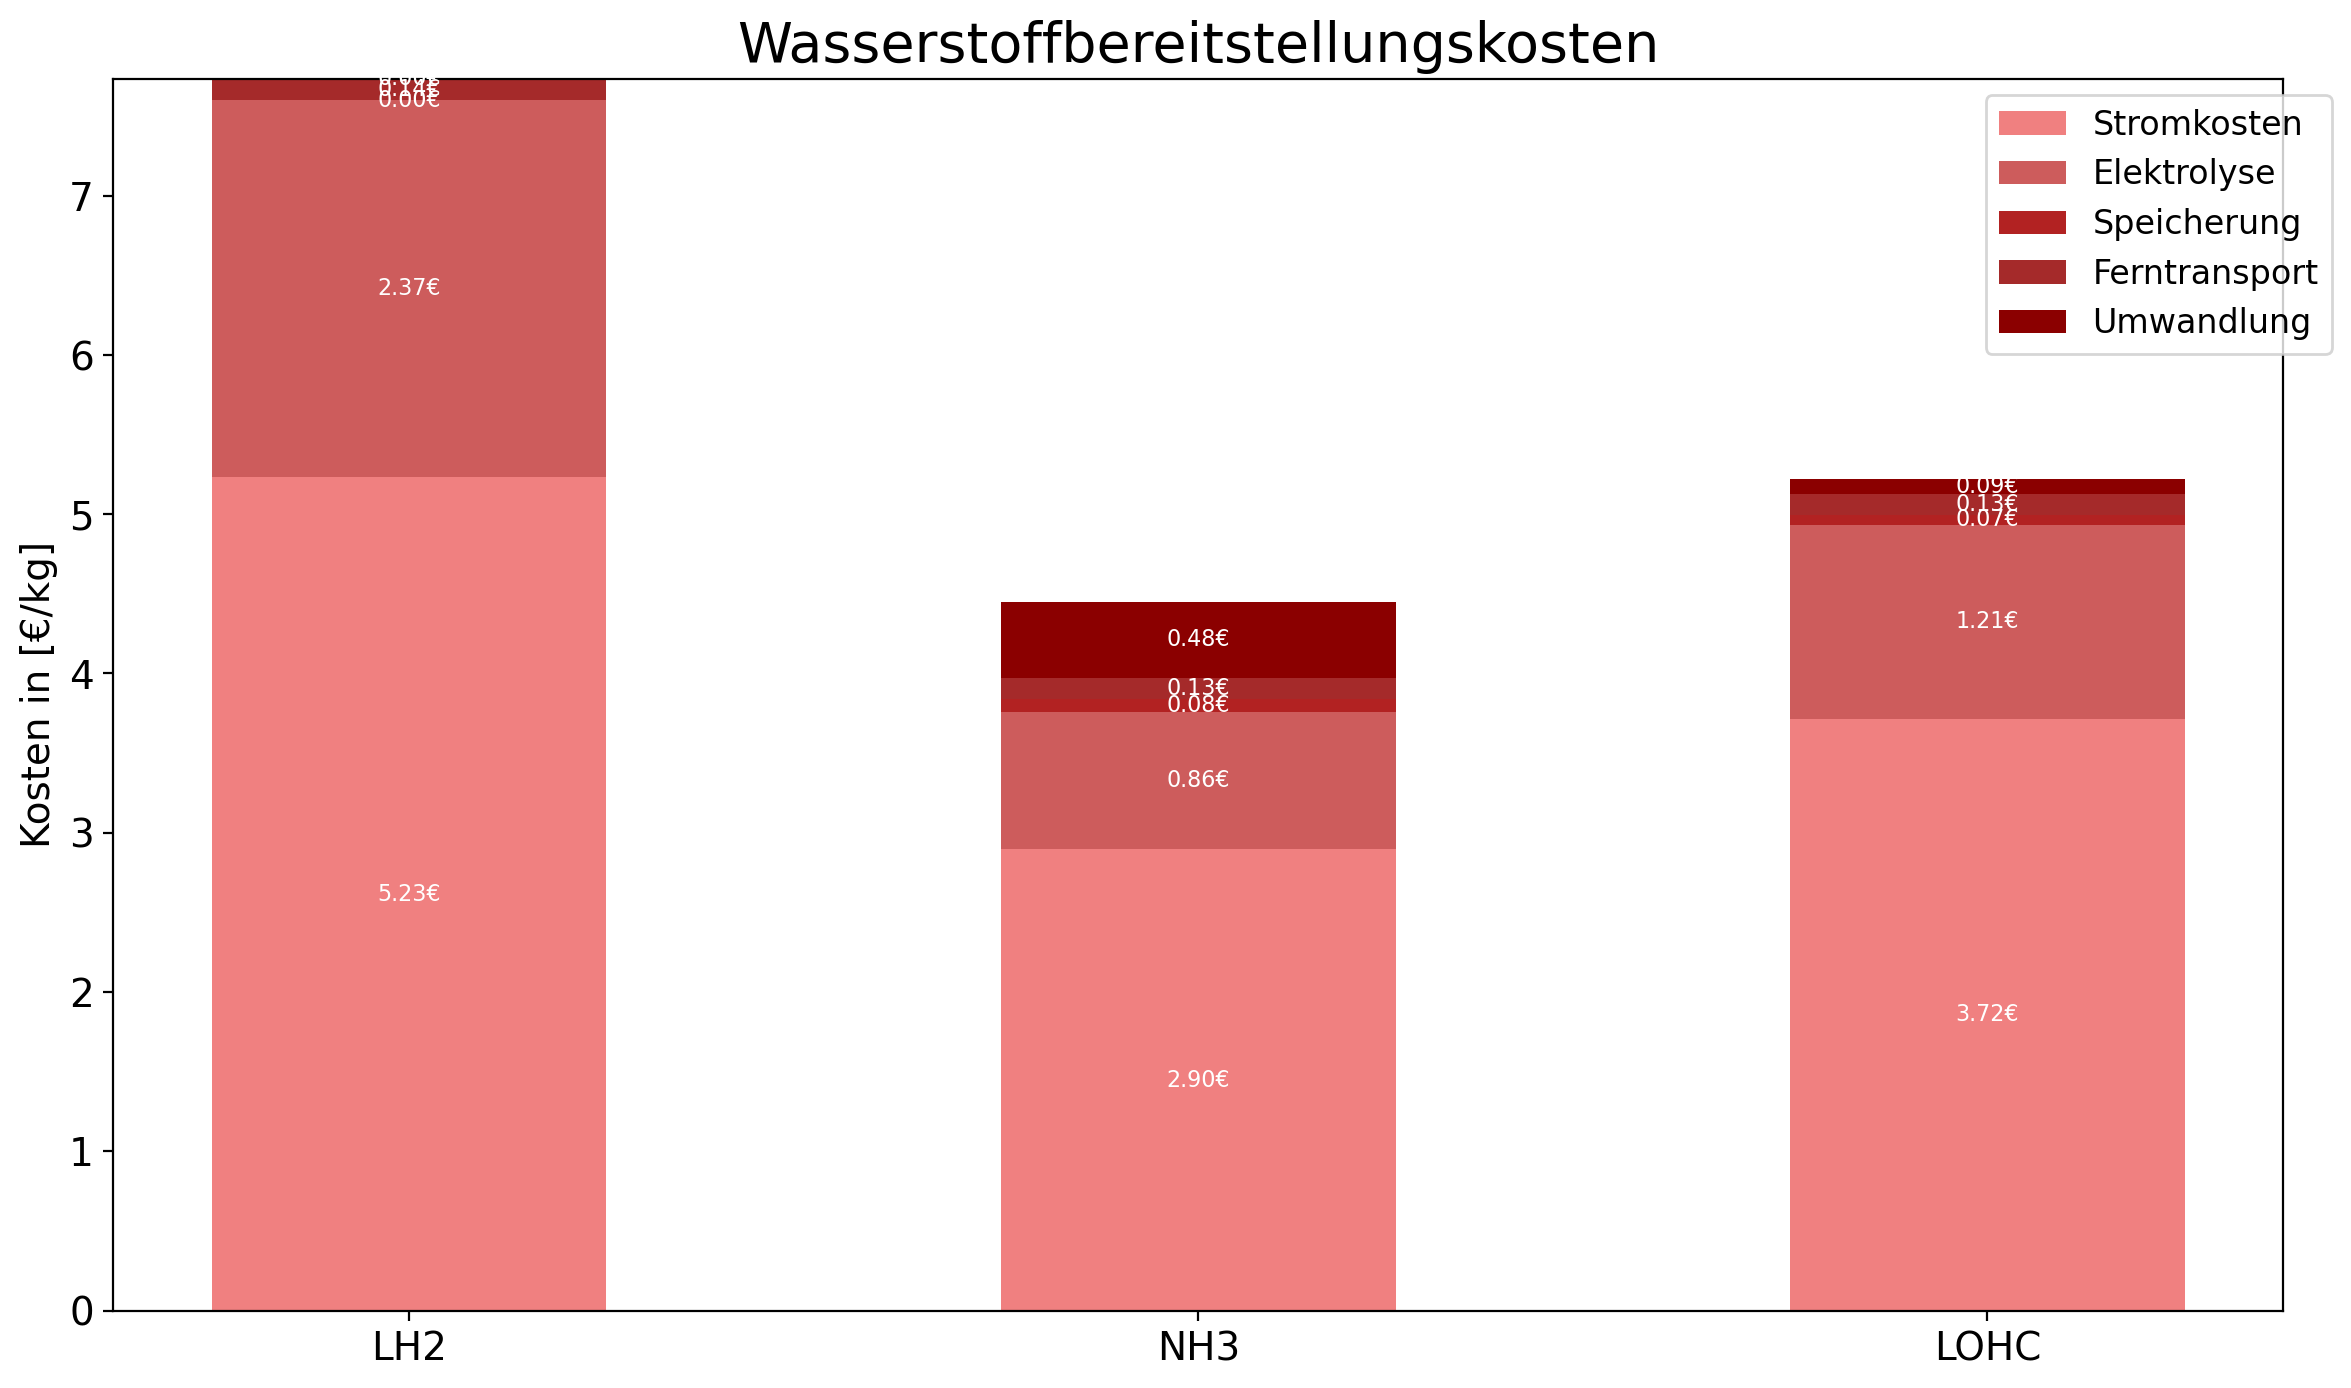

In [263]:
# Übersicht der Kilopreise

labels = ['LH2', 'NH3', 'LOHC']
Stromkosten = np.array([Gestehungskosten_Wasserstoff_1['Gestehungspreis [€/kg]']['Stromkosten'],
                        Gestehungskosten_Wasserstoff_2['Gestehungspreis [€/kg]']['Stromkosten'],
                         Gestehungskosten_Wasserstoff_3['Gestehungspreis [€/kg]']['Stromkosten']])

Elektrolyse = np.array([Gestehungskosten_Wasserstoff_1['Gestehungspreis [€/kg]']['Elektrolyse'],
                        Gestehungskosten_Wasserstoff_2['Gestehungspreis [€/kg]']['Elektrolyse'],
                         Gestehungskosten_Wasserstoff_3['Gestehungspreis [€/kg]']['Elektrolyse']])
                         
Umwandlung =  np.array([Gestehungskosten_Wasserstoff_1['Gestehungspreis [€/kg]']['Umwandlung'],
                        Gestehungskosten_Wasserstoff_2['Gestehungspreis [€/kg]']['Umwandlung'],
                         Gestehungskosten_Wasserstoff_3['Gestehungspreis [€/kg]']['Umwandlung']])
                          
Ferntransport_1 = np.array([Gestehungskosten_Wasserstoff_1['Gestehungspreis [€/kg]']['Transport'],
                        Gestehungskosten_Wasserstoff_2['Gestehungspreis [€/kg]']['Transport'],
                         Gestehungskosten_Wasserstoff_3['Gestehungspreis [€/kg]']['Transport']])

                         
Speicherung = np.array([Gestehungskosten_Wasserstoff_1['Gestehungspreis [€/kg]']['Speicherung'],
                        Gestehungskosten_Wasserstoff_2['Gestehungspreis [€/kg]']['Speicherung'],
                         Gestehungskosten_Wasserstoff_3['Gestehungspreis [€/kg]']['Speicherung']])

width=0.5
fig, ax = plt.subplots(figsize=(14,8))
ax.bar(labels, Stromkosten, label='Stromkosten',width=width,color='lightcoral')
ax.bar(labels, Elektrolyse, bottom=Stromkosten,
       label='Elektrolyse',width=width,color='indianred')
ax.bar(labels, Speicherung, bottom=Stromkosten+Elektrolyse,
       label='Speicherung',width=width,color='firebrick')
ax.bar(labels, Ferntransport_1, bottom=Stromkosten+Elektrolyse+Speicherung,
       label='Ferntransport',width=width,color='brown')
ax.bar(labels, Umwandlung, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1,
       label='Umwandlung',width=width,color='darkred')

ax.set_ylabel('Kosten in [€/kg]')
ax.set_title('Wasserstoffbereitstellungskosten')
ax.legend(loc='upper right')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.02f}€'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white',
            fontsize=8,
            )
  

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))

plt.show()

### Vergleich von Umwandlung und Ferntransport

In [267]:
Betrachtungszeitraum = 300 # Tag(e)

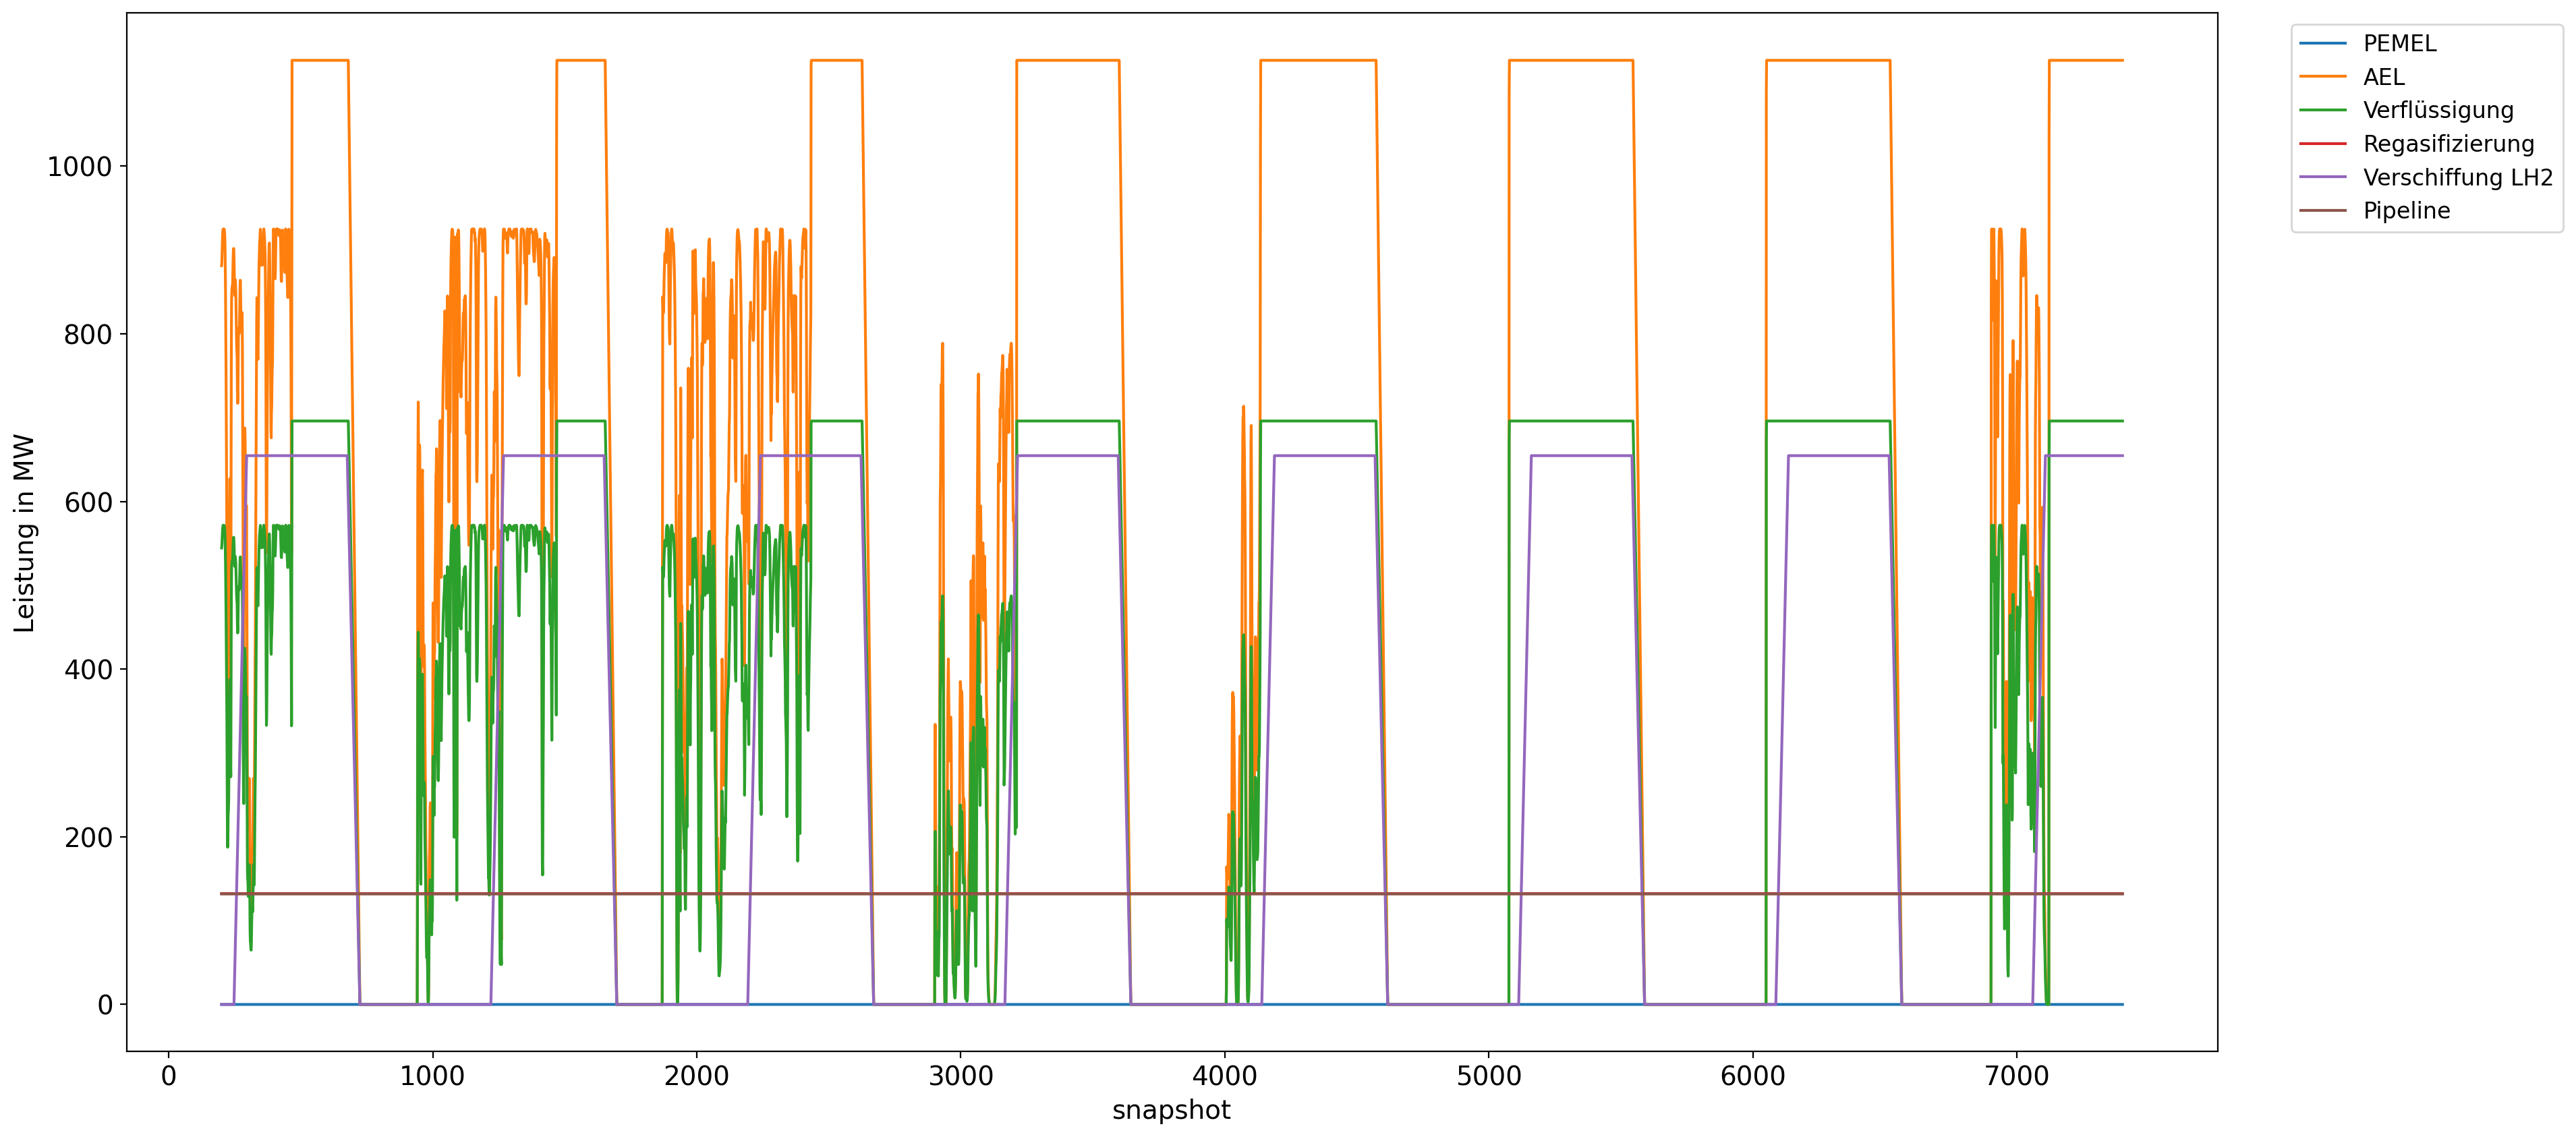

In [268]:
# Plot

a=200
b=a+Betrachtungszeitraum*24

ax=network1.links_t.p0.loc[a:b].plot(ylabel = 'Leistung in MW')
horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.show()

### Vergleich von Speicherung und Ferntransport

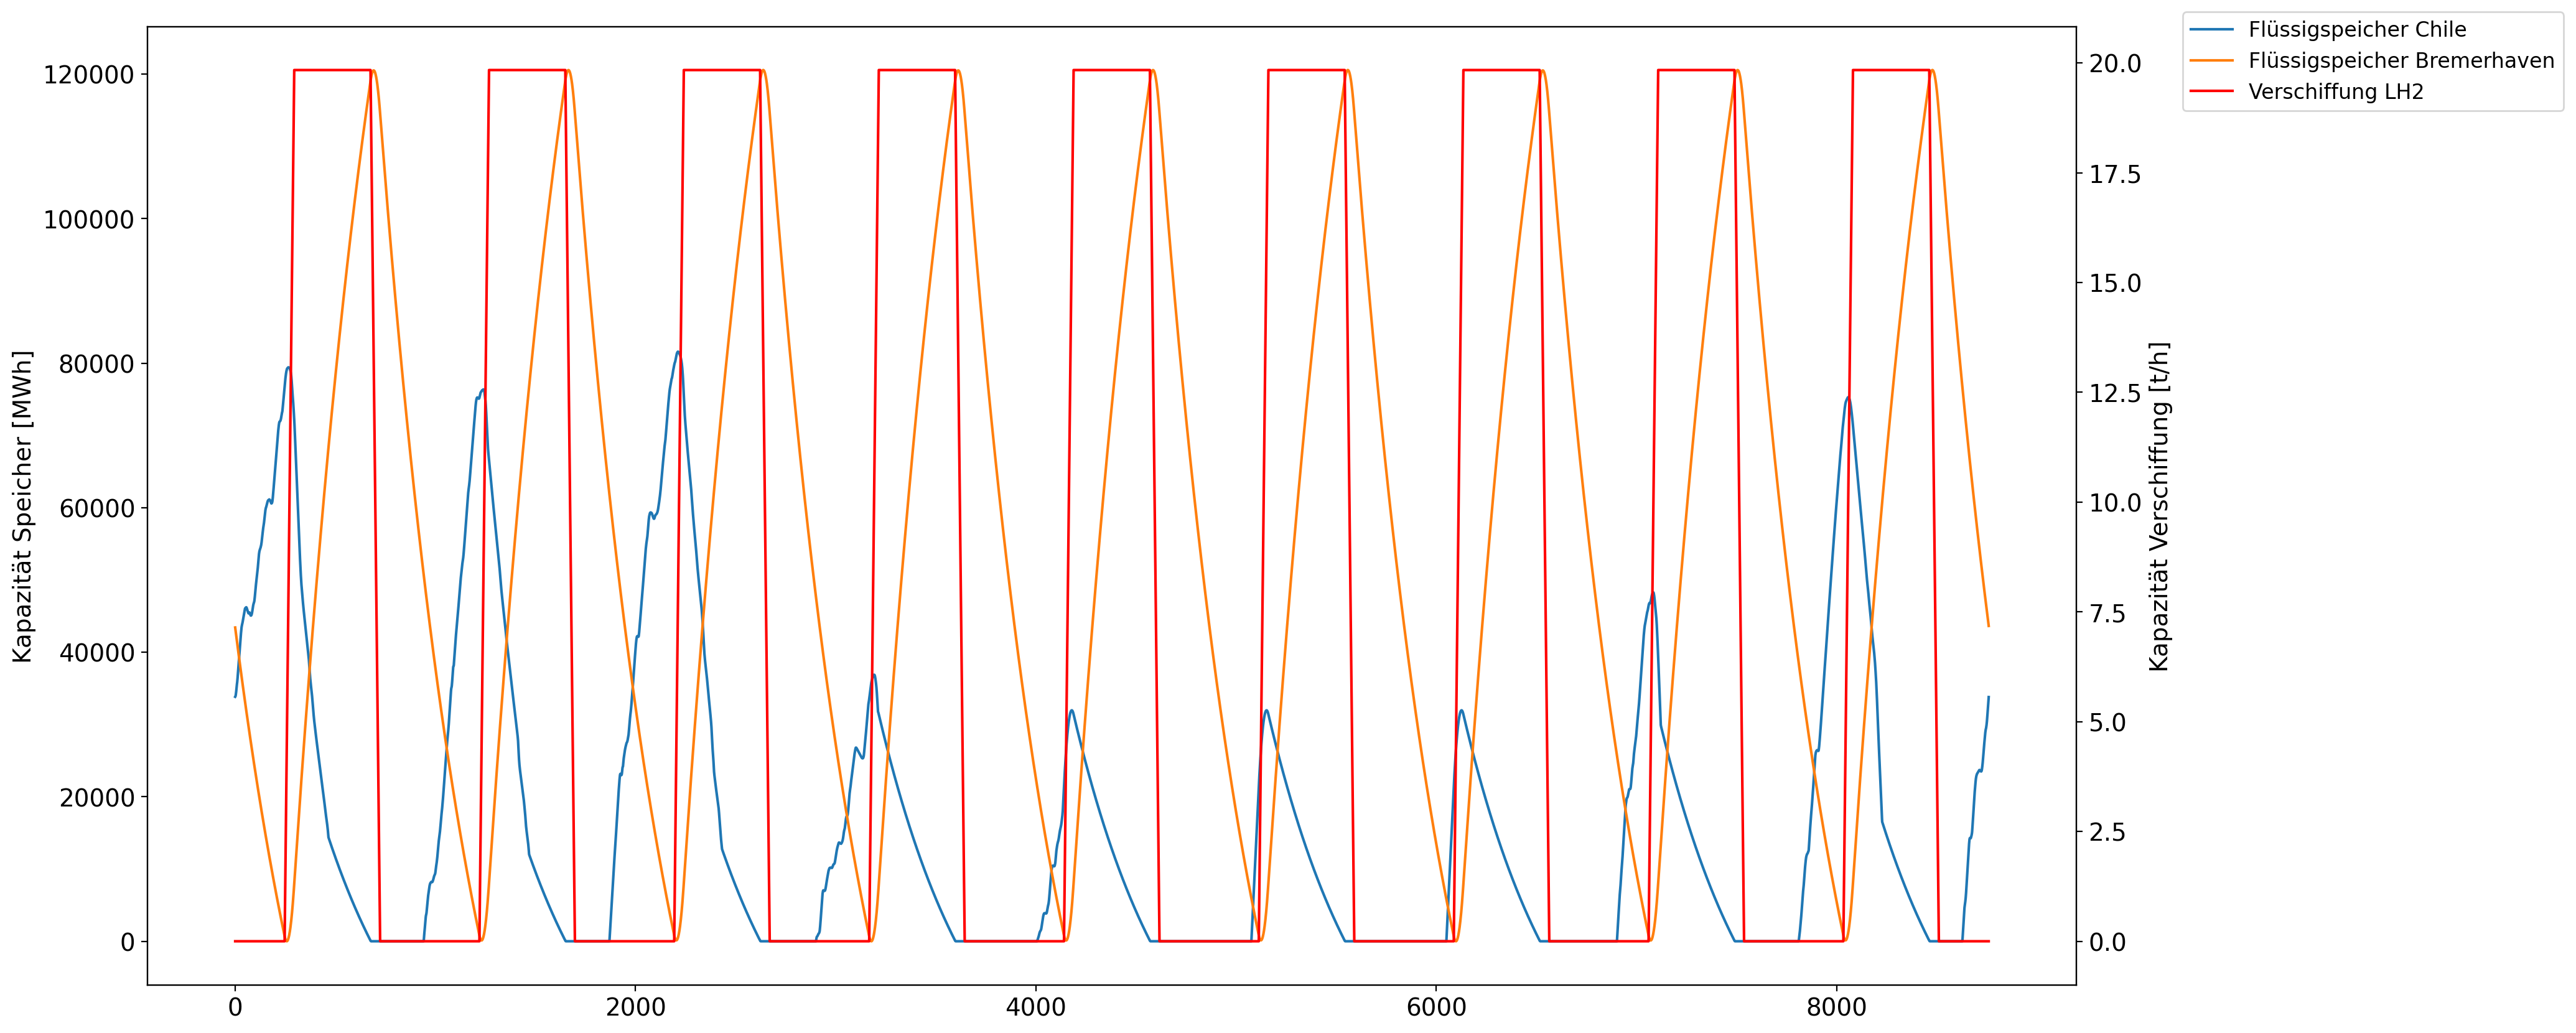

In [266]:
# Plot_AEL&PEM_ Speicher_und_Verschiffung

a=0
b=8760
fig, ax1 = plt.subplots(sharey = True)
Verschiffung_Tonnen=network1.links_t.p0['Verschiffung LH2']/33
ax2 = ax1.twinx()
ax2.plot(Verschiffung_Tonnen.loc[a:b],
        label = 'Verschiffung LH2',color='red')
ax1.plot(network1.stores_t.e['Flüssigspeicher Chile'].loc[a:b],
        label = 'Flüssigspeicher Chile')
ax1.plot(network1.stores_t.e['Flüssigspeicher Bremerhaven'].loc[a:b],
        label = 'Flüssigspeicher Bremerhaven')
ax2.set_ylabel('Kapazität Verschiffung [t/h]')
ax1.set_ylabel('Kapazität Speicher [MWh]')


horiz_offset = 1.1
vert_offset = 0.90
fig.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.show()

# Werkstatt